# Predviđanje broja gostiju na dnevnoj, tjednoj i mjesečnoj bazi koristeći statistički model ARIMA

**Rezultati za predikciju broja gostiju gostiju** 
- Hotel booking demand dataset
    - Dnevne predikcije
        - Test MAPE City Hotel/%: xx
        - Test MAPE Resort Hotel/%: xx
    - Tjedne predikcije
        - Test MAPE City Hotel/%: xx
        - Test MAPE Resort Hotel/%: xx
    - Mjesečne predikcije
        - Test MAPE City Hotel/%: xx
        - Test MAPE Resort Hotel/%: xx
**Rezultati za predikciju broja dolaska novih gostiju** 
- Hotel booking demand dataset
    - Dnevne predikcije
        - Test MAPE City Hotel/%: 0.269380
        - Test MAPE Resort Hotel/%: 0.277995
    - Tjedne predikcije
        - Test MAPE City Hotel/%: 0.610819
        - Test MAPE Resort Hotel/%: 0.189251
    - Mjesečne predikcije
        - Test MAPE City Hotel/%: 0.583682
        - Test MAPE Resort Hotel/%: 0.109033

- Lumen dataset `data/interim/data_wo_cancel.parquet`
- Hotel 0 dataset `data/interim/data_wo_cancel_hotel0.parquet`
- Hotel 1 dataset `data/interim/data_wo_cancel_hotel1.parquet`

| Hotel Type | Data Frequency | Mean Abs Percentage Error (%) | Mean Squared Error | Root Mean Squared Error |
|------------|----------------|-------------------------------|--------------------|-------------------------|
| City       | Daily          | 0.269380                      | 1163.264705        | 34.106667               |
| City       | Weekly         | 0.610819                      | 245406.918078      | 495.385626              |
| City       | Monthly        | 0.583682                      | 4447887.766771     | 2109.001604             |
| Resort     | Daily          | 0.277995                      | 768.783166         | 27.726939               |
| Resort     | Weekly         | 0.189251                      | 13023.739130       | 114.121598              |
| Resort     | Monthly        | 0.109033                      | 97302.000000       | 311.932685              |


# Učitavanje modula

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error
import os
import random 

for dirname, _, filenames in os.walk('..\\data\\raw'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
warnings.filterwarnings("ignore")

# Učitavanje podataka 

In [3]:
DATA_CLEANED_PATH = '../data/interim/data_no_cancellations.parquet'
DATA_HOTEL0_BASE_PATH = '../data/interim/hotel_0'
DATA_HOTEL1_BASE_PATH = '../data/interim/hotel_1'
DATA_HOTEL0_PATH = '../data/interim/hotel_0/hotel0cleaned.parquet'
DATA_HOTEL1_PATH = '../data/interim/hotel_0/hotel0cleaned.parquet'


In [4]:
data = pd.read_parquet(DATA_CLEANED_PATH)
dataResort = pd.read_parquet(DATA_HOTEL0_PATH)
dataCity = pd.read_parquet(DATA_HOTEL1_PATH)
data.head()

,hotel_id,datum_dolaska,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,gost_id,ukupno_gostiju,duljina_boravka,raspon_dolazak_rezervacija
0,0,2015-07-01,GBR,0,1,64.991345,1039896,1,1,49
1,0,2015-07-01,GBR,1,1,74.368897,1008245,1,1,397
2,0,2015-07-01,GBR,2,1,130.973278,1093703,2,2,360
3,0,2015-07-01,GBR,2,1,143.304560,1044263,2,2,71
4,0,2015-07-01,PRT,0,0,161.502814,1022260,2,2,6


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73936 entries, 0 to 73935
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   hotel_id                    73936 non-null  int32         
 1   datum_dolaska               73936 non-null  datetime64[ns]
 2   zemlja_gosta                73936 non-null  object        
 3   kanal_prodaje_id            73936 non-null  int32         
 4   tip_sobe_id                 73936 non-null  int32         
 5   cijena_nocenja              73936 non-null  float64       
 6   gost_id                     73936 non-null  int32         
 7   ukupno_gostiju              73936 non-null  int64         
 8   duljina_boravka             73936 non-null  int64         
 9   raspon_dolazak_rezervacija  73936 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(4), int64(3), object(1)
memory usage: 4.5+ MB


In [7]:
NaN = data.isna().sum()
NaN

hotel_id                      0
datum_dolaska                 0
zemlja_gosta                  0
kanal_prodaje_id              0
tip_sobe_id                   0
cijena_nocenja                0
gost_id                       0
ukupno_gostiju                0
duljina_boravka               0
raspon_dolazak_rezervacija    0
dtype: int64

### Učitavanje broja gostiju, broja dolazaka i broja novih gostiju u nekom periodu, na dnevnoj, tjednoj, mjesečnoj i godišnjoj razini za oba hotela

### City Hotel

#### Dnevna razina

In [8]:
NumberOfGuestsDailyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "daily", "daily_guests.parquet"))
NumberOfArrivalsDailyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "daily", "daily_arrivals.parquet"))
NumberOfNewGuestsDailyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "daily", "daily_new_guests.parquet"))


In [25]:
NumberOfGuestsDailyCity.head(5)

,ukupno_gostiju
datum,
2015-01-01,10
2015-01-02,16
2015-01-03,27
2015-01-04,27
2015-01-05,28


#### Tjedna razina

In [23]:
NumberOfGuestsWeeklyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "weekly", "weekly_guests.parquet"))
NumberOfArrivalsWeeklyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "weekly", "weekly_arrivals.parquet"))
NumberOfNewGuestsWeeklyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "weekly", "weekly_new_guests.parquet"))

In [26]:
NumberOfNewGuestsWeeklyCity.head()

,ukupno_gostiju
datum_dolaska,
2015-01-04,35
2015-01-11,42
2015-01-18,54
2015-01-25,48
2015-02-01,27


In [24]:
NumberOfGuestsWeeklyCity.head()

,ukupno_gostiju
datum,
2015-01-04,80
2015-01-11,179
2015-01-18,161
2015-01-25,217
2015-02-01,117


#### Mjesečna razina

In [26]:
NumberOfGuestsMonthlyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "monthly", "monthly_guests.parquet"))
NumberOfArrivalsMonthlyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "monthly", "monthly_arrivals.parquet"))
NumberOfNewGuestsMonthlyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "monthly", "monthly_new_guests.parquet"))


In [22]:
NumberOfGuestsMonthlyCity.head()

NameError: name 'NumberOfGuestsMonthlyCity' is not defined

#### Godišnja razina

In [28]:
NumberOfGuestsYearlyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "yearly", "yearly_guests.parquet"))
NumberOfArrivalsYearlyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "yearly", "yearly_arrivals.parquet"))
NumberOfNewGuestsYearlyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "yearly", "yearly_new_guests.parquet"))

In [29]:
NumberOfGuestsYearlyCity.head()

,ukupno_gostiju
datum,
2015-12-31,51073
2016-12-31,175098
2017-12-31,130534
2018-12-31,770


#### Problemi s anomalija kod City Hotela za dolaske novih gostiju (npr. 0 novih gostiju u nekim danima)

In [40]:
indexes = NumberOfNewGuestsDailyCity[NumberOfNewGuestsDailyCity['ukupno_gostiju'] == 0].index
periods = []
start_date = indexes[0]
for i in range(1, len(indexes)):
    if (indexes[i] - indexes[i-1]).days > 1:
        end_date = indexes[i-1]
        periods.append((start_date, end_date))
        start_date = indexes[i]

periods.append((start_date, indexes[-1]))

for start, end in periods:
    print(f"Periodi gdje je broj gostiju jednak nuli : od {start.date()} do {end.date()}, ukupno {(end - start).days+1} dana")

Periodi gdje je broj gostiju jednak nuli : od 2015-02-01 do 2015-04-30, ukupno 89 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-06-01 do 2015-06-30, ukupno 30 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-05 do 2015-07-06, ukupno 2 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-12 do 2015-07-14, ukupno 3 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-16 do 2015-07-16, ukupno 1 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-19 do 2015-07-19, ukupno 1 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-21 do 2015-07-21, ukupno 1 dana
Periodi gdje je broj gostiju jednak nuli : od 2017-09-01 do 2017-09-30, ukupno 30 dana


In [41]:
indexes_valid = NumberOfNewGuestsDailyCity[NumberOfNewGuestsDailyCity['ukupno_gostiju'] != 0].index
periods_valid = []
start_date = indexes_valid[0]
for i in range(1, len(indexes_valid)):
    if (indexes_valid[i] - indexes_valid[i-1]).days > 1:
        end_date = indexes_valid[i-1]
        periods_valid.append((start_date, end_date))
        start_date = indexes_valid[i]

periods_valid.append((start_date, indexes_valid[-1]))

for start, end in periods_valid:
    print(f"Periodi gdje je broj gostiju različit nuli : od {start.date()} do {end.date()}, ukupno {(end - start).days+1} dana")

Periodi gdje je broj gostiju različit nuli : od 2015-01-01 do 2015-01-31, ukupno 31 dana
Periodi gdje je broj gostiju različit nuli : od 2015-05-01 do 2015-05-31, ukupno 31 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-01 do 2015-07-04, ukupno 4 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-07 do 2015-07-11, ukupno 5 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-15 do 2015-07-15, ukupno 1 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-17 do 2015-07-18, ukupno 2 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-20 do 2015-07-20, ukupno 1 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-22 do 2017-08-31, ukupno 772 dana
Periodi gdje je broj gostiju različit nuli : od 2017-10-01 do 2017-12-31, ukupno 92 dana


ZAKLJUČAK
- dio podataka gdje je duljina perioda gdje hotel nema gostiju dulja od tjedan dana ima smisla izbaciti, zajedno s podacima koji prethode, ako govorimo o "malom "uzorku "čistih" podataka koji prethode dugim anomalijama
- kako je taj "mali" uzorak podataka koji smijemo izbaciti arbitraran, moguće je modelirati na više načina, s većom/manjom količinom izbacivanja podataka
- manje periode ima smisla modelirati na način da se agregiraju srednje vrijednosti podatka iz susjedstva (npr. tjedan dana prije i poslije) ili interpolirati srednje vrijednosti iz susjedstva
- prethodno može biti primjenjemo na dulje periode, ukoliko je potrebno
- ARIMA model, kao i MAPE metrika, ne reagiraju dobro na anomalije, odnosno MAPE puca (zbog djeljenja s nulom) ako su ciljani podaci nula, odnosno u ovom slučaju za svaki slučaj kada je broj ukupnih gosti na bilo kojoj vremenskoj bazi jednak nuli


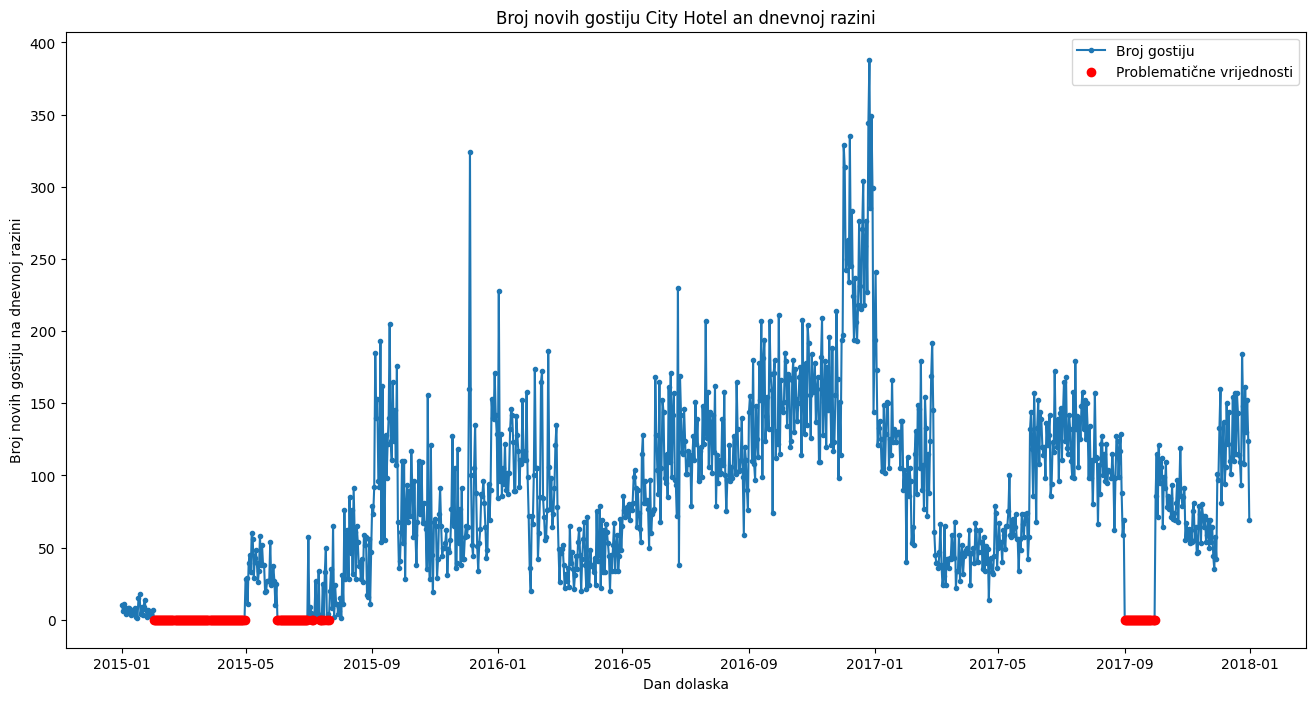

In [43]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfNewGuestsDailyCity['ukupno_gostiju'], marker='.', label='Broj gostiju')
plt.plot(NumberOfNewGuestsDailyCity.loc[indexes, 'ukupno_gostiju'], 'o', color='red', label='Problematične vrijednosti')

plt.title('Broj novih gostiju City Hotel an dnevnoj razini')
plt.xlabel('Dan dolaska')
plt.ylabel('Broj novih gostiju na dnevnoj razini')

plt.legend()
plt.show()

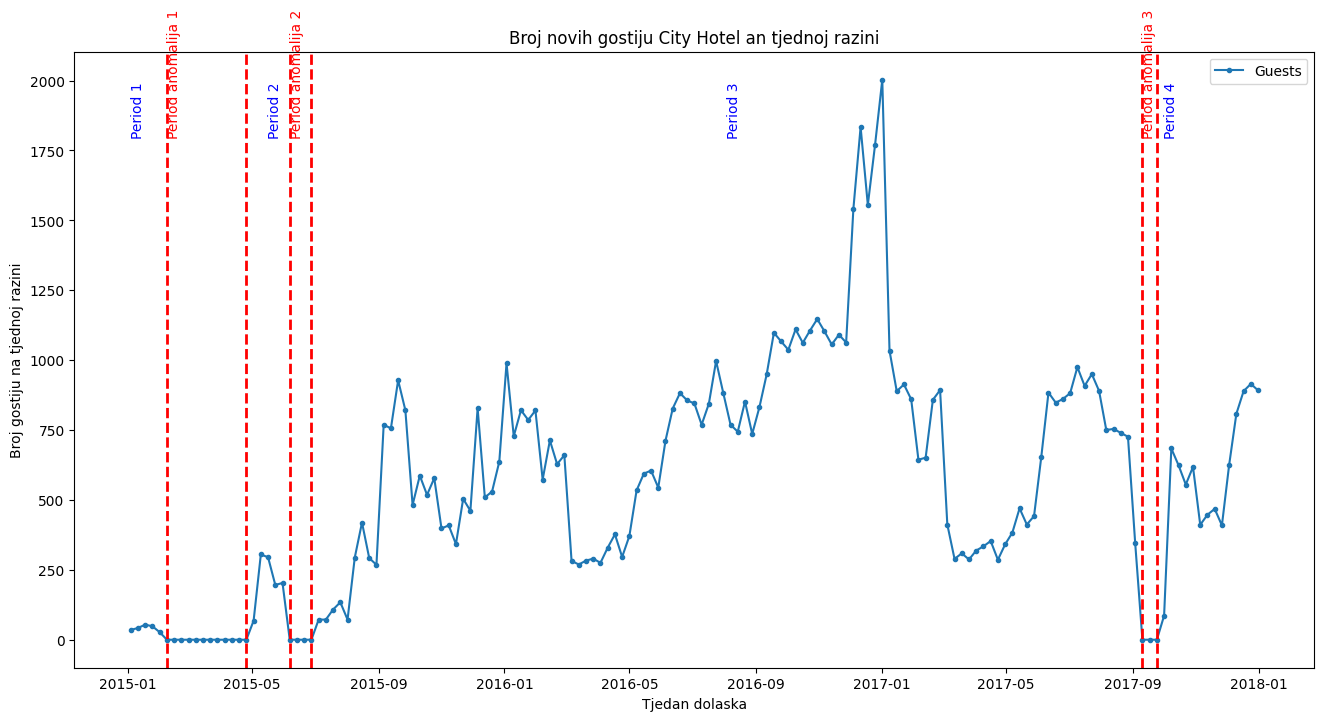

In [44]:
indexes = NumberOfNewGuestsWeeklyCity[NumberOfNewGuestsWeeklyCity['ukupno_gostiju'] == 0].index
periods = []
start_date = indexes[0]

for i in range(1, len(indexes)):
    if (indexes[i] - indexes[i - 1]).days > 7:  
        end_date = indexes[i - 1]
        periods.append((start_date, end_date))
        start_date = indexes[i]

periods.append((start_date, indexes[-1]))

plt.figure(figsize=(16, 8))
plt.plot(NumberOfNewGuestsWeeklyCity['ukupno_gostiju'], marker='.', label='Guests')

anomalous_period_count = 1
normal_period_count = 1

if periods[0][0] != NumberOfNewGuestsWeeklyCity.index.min():
    first_normal_end = periods[0][0] - pd.Timedelta(weeks=1)
    plt.text(NumberOfNewGuestsWeeklyCity.index.min(), max(NumberOfNewGuestsWeeklyCity['ukupno_gostiju']) * 0.9, f'Period {normal_period_count}', color='blue', rotation=90)
    normal_period_count += 1

for i, (start, end) in enumerate(periods):
    plt.axvline(x=start, color='red', linestyle='--', lw=2)
    plt.axvline(x=end, color='red', linestyle='--', lw=2)
    plt.text(start, max(NumberOfNewGuestsWeeklyCity['ukupno_gostiju']) * 0.9, f'Period anomalija {anomalous_period_count}', color='red', rotation=90)
    anomalous_period_count += 1

    if i < len(periods) - 1:
        next_start = periods[i + 1][0]
        midpoint = pd.to_datetime((end.value + next_start.value) // 2)
        plt.text(midpoint, max(NumberOfNewGuestsWeeklyCity['ukupno_gostiju']) * 0.9, f'Period {normal_period_count}', color='blue', rotation=90)
        normal_period_count += 1

if periods[-1][1] != NumberOfGuestsWeeklyCity.index.max():
    last_normal_start = periods[-1][1] + pd.Timedelta(weeks=1)
    plt.text(last_normal_start, max(NumberOfNewGuestsWeeklyCity['ukupno_gostiju']) * 0.9, f'Period {normal_period_count}', color='blue', rotation=90)
    normal_period_count += 1

plt.title('Broj novih gostiju City Hotel an tjednoj razini')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na tjednoj razini')

plt.legend()
plt.show()


KOMENTAR
- period 1, 2 te 3 označavaju periode podatak iz dataseta gdje postoji dnevni broj gostiju različit od nule, dok periodi anomalija vremenske
periode gdje je ukupan broj gostiju jedan nuli
- prvi period anomalija ćemo izbaciti iz dataseta, kao i period 1 regularnih podataka, kako se radi o kratkom peroidu validnih podataka 
 (imamo 30 dana zapisa i 88 dana bez gostiju)
- drugi period anomalija, kao i treći, razrješiti će se na sljedeći način:
   - za drugi period anomalija gledati ćemo period 2 te određeni dio perioda 3 "zdravih podataka" te izračunati daily mean te dodati tu vrijednosti danima anomalija
   - za treći period koristiti ćemo dio trećeg te četvrtog perioda zdravih podataka i na taj način amputirati podatke u dane anomalija
- ovo se treba raditi na  podatkovnom okviru s dnevnim zapisima, kako na tjednoj razini ne vidimo veću granulaciju, odnosno postoje dani (jedan ili dva u nizu) u kojima 
  nema gostiju, ali koji se "ne vide" na tjednoj bazi,ali utječu na brog gostiju

#### Brisanje, umetanje podataka i vizualizacija

1.KORAK - brisanje podataka sve do kraja prvog područja anomalija - do 30-04-2015

In [45]:
cutoff_date = pd.to_datetime('2015-04-30')
dataCityClean = dataCity[dataCity['datum_dolaska'] >= cutoff_date]

In [46]:
NumberOfNewGuestsDailyCity = dataCityClean['ukupno_gostiju'].groupby(dataCityClean['datum_dolaska']).sum()
NumberOfNewGuestsDailyCity = NumberOfNewGuestsDailyCity.resample('d').sum().to_frame()
NumberOfGuestsDailyCity.head(5)

,ukupno_gostiju
datum,
2015-01-01,10
2015-01-02,16
2015-01-03,27
2015-01-04,27
2015-01-05,28


Periodi gdje je broj gostiju jednak nuli : od 2015-06-01 do 2015-06-30, ukupno 30 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-05 do 2015-07-06, ukupno 2 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-12 do 2015-07-14, ukupno 3 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-16 do 2015-07-16, ukupno 1 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-19 do 2015-07-19, ukupno 1 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-21 do 2015-07-21, ukupno 1 dana
Periodi gdje je broj gostiju jednak nuli : od 2017-09-01 do 2017-09-30, ukupno 30 dana


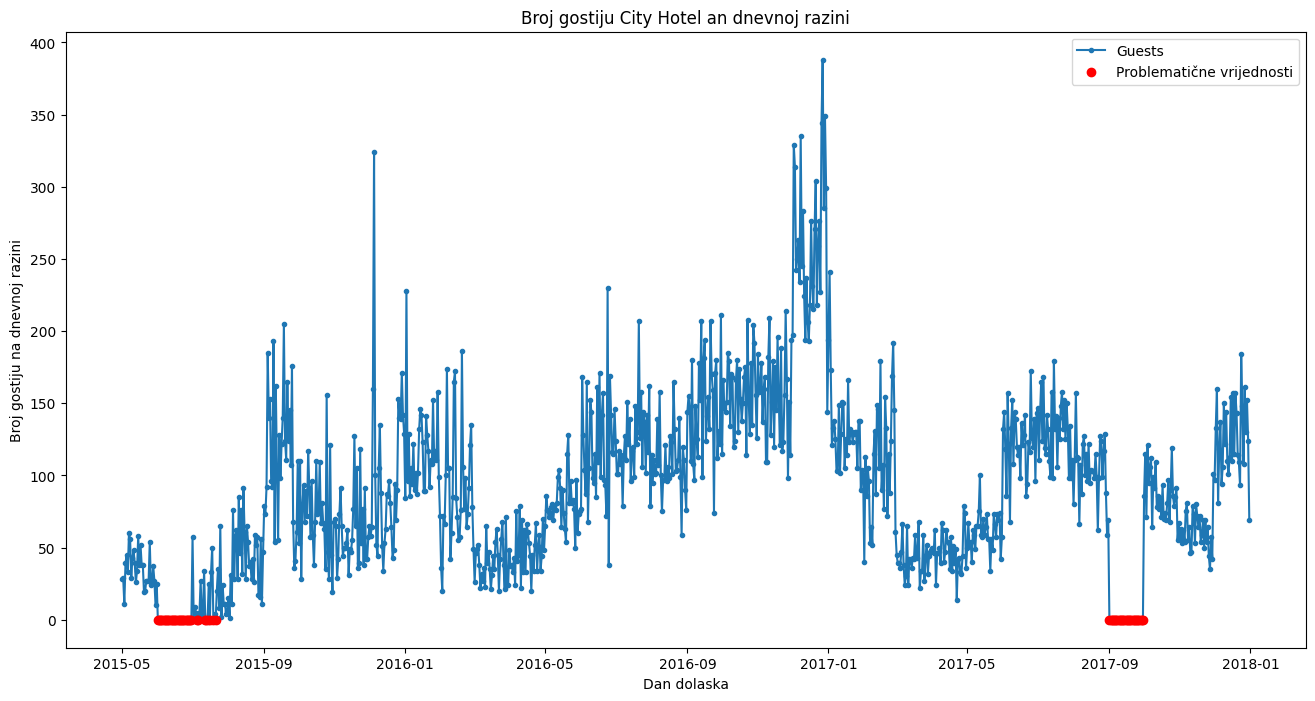

In [49]:
indexes = NumberOfNewGuestsDailyCity[NumberOfNewGuestsDailyCity['ukupno_gostiju'] == 0].index
periods = []
start_date = indexes[0]
for i in range(1, len(indexes)):
    if (indexes[i] - indexes[i-1]).days >1:
        end_date = indexes[i-1]
        periods.append((start_date, end_date))
        start_date = indexes[i]

periods.append((start_date, indexes[-1]))
for start, end in periods:
    print(f"Periodi gdje je broj gostiju jednak nuli : od {start.date()} do {end.date()}, ukupno {(end - start).days+1} dana")
    
plt.figure(figsize=(16, 8))

plt.plot(NumberOfNewGuestsDailyCity['ukupno_gostiju'], marker='.', label='Guests')
plt.plot(NumberOfNewGuestsDailyCity.loc[indexes, 'ukupno_gostiju'], 'o', color='red', label='Problematične vrijednosti')

plt.title('Broj gostiju City Hotel an dnevnoj razini')
plt.xlabel('Dan dolaska')
plt.ylabel('Broj gostiju na dnevnoj razini')

plt.legend()
plt.show()

2.KORAK -umetanje podataka

In [51]:
indexes_valid = NumberOfNewGuestsDailyCity[NumberOfNewGuestsDailyCity['ukupno_gostiju'] != 0].index
periods_valid = []
start_date = indexes_valid[0]
for i in range(1, len(indexes_valid)):
    if (indexes_valid[i] - indexes_valid[i-1]).days > 1:
        end_date = indexes_valid[i-1]
        periods_valid.append((start_date, end_date))
        start_date = indexes_valid[i]

periods_valid.append((start_date, indexes_valid[-1]))

for start, end in periods_valid:
    print(f"Periodi gdje je broj gostiju različit nuli : od {start.date()} do {end.date()}, ukupno {(end - start).days+1} dana")

Periodi gdje je broj gostiju različit nuli : od 2015-05-01 do 2015-05-31, ukupno 31 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-01 do 2015-07-04, ukupno 4 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-07 do 2015-07-11, ukupno 5 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-15 do 2015-07-15, ukupno 1 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-17 do 2015-07-18, ukupno 2 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-20 do 2015-07-20, ukupno 1 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-22 do 2017-08-31, ukupno 772 dana
Periodi gdje je broj gostiju različit nuli : od 2017-10-01 do 2017-12-31, ukupno 92 dana


In [53]:
def calculate_mean_for_window(start, end):
    window_data = NumberOfNewGuestsDailyCity[(NumberOfNewGuestsDailyCity.index >= start) & (NumberOfNewGuestsDailyCity.index <= end)]
    #print(window_data)
    return window_data['ukupno_gostiju'].mean()

In [54]:
for start, end in periods:
    period_length = (end - start).days

    if period_length == 1:
        window_start_before = start - pd.Timedelta(days=1)
        window_end_after = end + pd.Timedelta(days=1)
    elif period_length < 3:
        window_start_before = start - pd.Timedelta(days=4) #moguće mijenati veličinu prozora
        window_end_after = end + pd.Timedelta(days=4) #moguće mijenati veličinu prozora
    else:
        window_start_before = start - pd.Timedelta(days=6) #moguće mijenati veličinu prozora
        window_end_after = end + pd.Timedelta(days=6) #moguće mijenati veličinu prozora

    window_start_before = max(window_start_before, NumberOfNewGuestsDailyCity.index.min())
    window_end_after = min(window_end_after, NumberOfNewGuestsDailyCity.index.max())

    mean_before = calculate_mean_for_window(window_start_before, start - pd.Timedelta(days=1))
    mean_after = calculate_mean_for_window(end + pd.Timedelta(days=1), window_end_after)

    mean_value = (mean_before + mean_after) / 2

    for day in pd.date_range(start, end):
        if day in NumberOfNewGuestsDailyCity.index:
            variance_percentage = random.uniform(-0.2, 0.2)  # +/- 20%  varijance kako bismo simulirali stvarne podatke
            varied_mean_value = mean_value + (mean_value * variance_percentage)
            NumberOfNewGuestsDailyCity.at[day, 'ukupno_gostiju'] = varied_mean_value

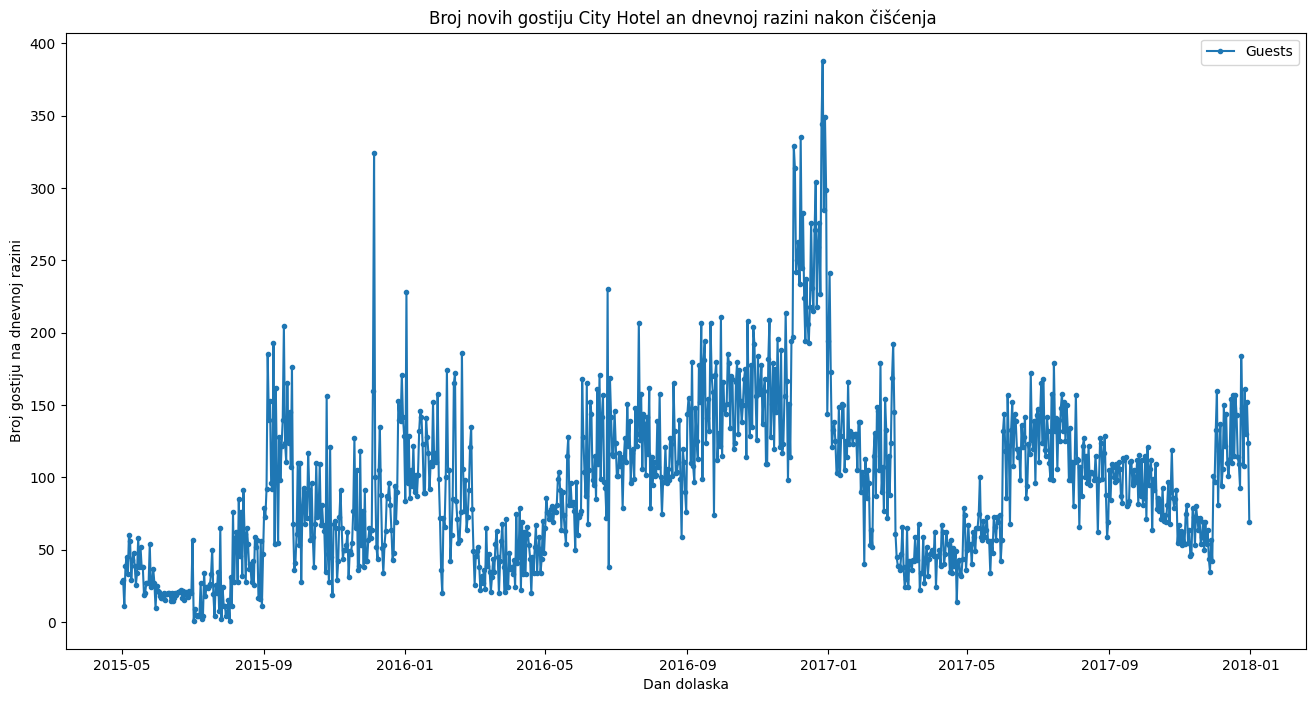

In [56]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfNewGuestsDailyCity['ukupno_gostiju'], marker='.', label='Guests')

plt.title('Broj novih gostiju City Hotel an dnevnoj razini nakon čišćenja ')
plt.xlabel('Dan dolaska')
plt.ylabel('Broj gostiju na dnevnoj razini')

plt.legend()
plt.show()

In [57]:
NumberOfNewGuestsWeeklyCity = NumberOfNewGuestsDailyCity.resample('W').sum()
NumberOfNewGuestsMonthlyCity = NumberOfNewGuestsDailyCity.resample('ME').sum()
NumberOfNewGuestsYearlyCity = NumberOfNewGuestsDailyCity.resample('Y').sum()


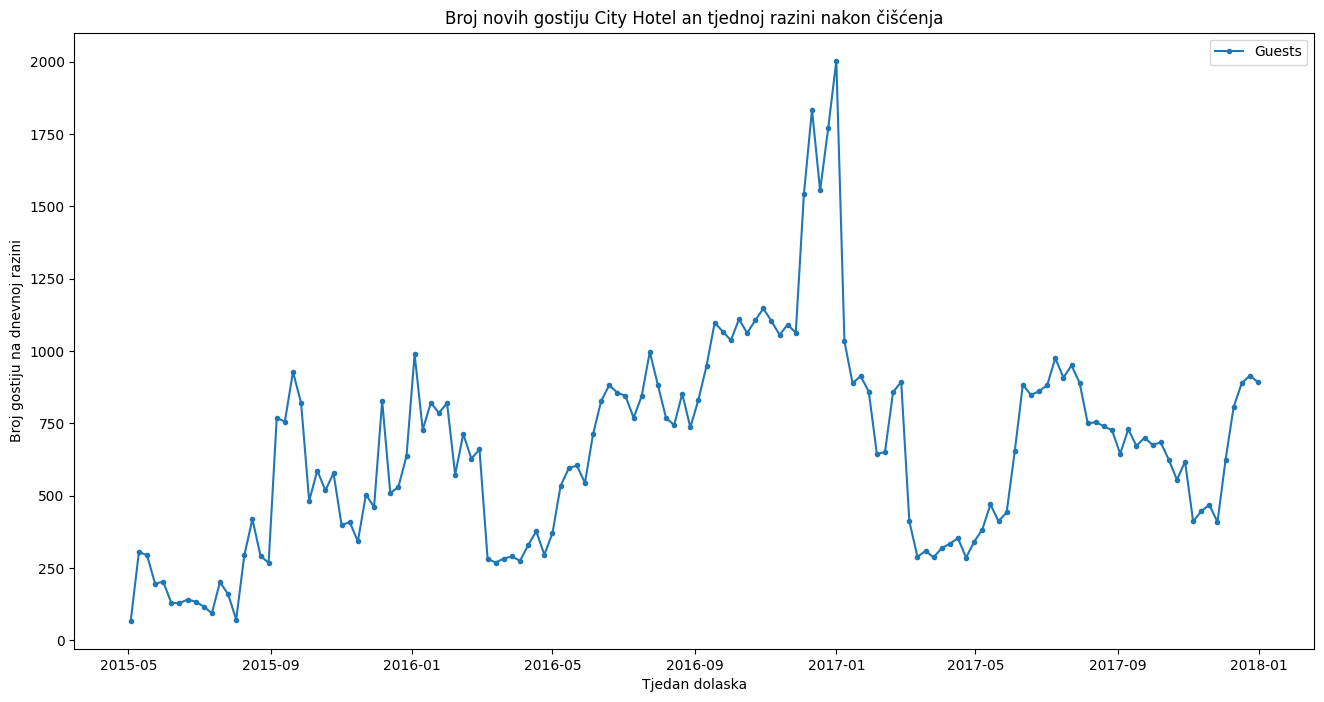

In [58]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfNewGuestsWeeklyCity['ukupno_gostiju'], marker='.', label='Guests')

plt.title('Broj novih gostiju City Hotel an tjednoj razini nakon čišćenja')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na dnevnoj razini')

plt.legend()
plt.show()

### Resort Hotel

#### Dnevna razina

In [32]:
NumberOfGuestsDailyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "daily", "daily_guests.parquet"))
NumberOfArrivalsDailyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "daily", "daily_arrivals.parquet"))
NumberOfNewGuestsDailyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "daily", "daily_new_guests.parquet"))

In [59]:
NumberOfGuestsDailyResort.head()

,ukupno_gostiju
datum,
2015-07-01,63
2015-07-02,135
2015-07-03,187
2015-07-04,245
2015-07-05,307


#### Tjedna razina

In [60]:
NumberOfGuestsWeeklyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "weekly", "weekly_guests.parquet"))
NumberOfArrivalsWeeklyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "weekly", "weekly_arrivals.parquet"))
NumberOfNewGuestsWeeklyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "weekly", "weekly_new_guests.parquet"))


In [61]:
NumberOfGuestsWeeklyResort.head(5)

,ukupno_gostiju
datum,
2015-07-05,937
2015-07-12,2823
2015-07-19,3264
2015-07-26,3331
2015-08-02,3349


#### Mjesečna razina

In [62]:
NumberOfGuestsMonthlyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "monthly", "monthly_guests.parquet"))
NumberOfArrivalsMonthlyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "monthly", "monthly_arrivals.parquet"))
NumberOfNewGuestsMonthlyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "monthly", "monthly_new_guests.parquet"))


In [63]:
NumberOfGuestsMonthlyResort.head(5)

,ukupno_gostiju
datum,
2015-07-31,12730
2015-08-31,14798
2015-09-30,12806
2015-10-31,11456
2015-11-30,7085


#### Godišnja razina

In [64]:
NumberOfGuestsYearlyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "yearly", "yearly_guests.parquet"))
NumberOfArrivalsYearlyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "yearly", "yearly_arrivals.parquet"))
NumberOfNewGuestsYearlyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "yearly", "yearly_new_guests.parquet"))

In [65]:
NumberOfGuestsYearlyResort.head(5)

,ukupno_gostiju
datum,
2015-12-31,65417
2016-12-31,133813
2017-12-31,97517


# Predikcija broja novih gostiju

## ARIMA model za predviđanje budućeg broja novih gostiju - City Hotel

### Predviđanje dnevnog broja novih gostiju 


#### Dickey-Fuller test za podatke o dnevnom broju novih gostiju

##### Augmented Dickey-Fuller (ADF) test se koristi u statistici i ekonometriji za testiranje prisutnosti tzv. "jediničnog korijena" (unit root) u vremenskim serijama
##### Jedinični korijen ukazuje na to da vremenska serija nije stacionarna, što znači da njene statističke karakteristike kao što su srednja vrijednost, varijanca i autokorelacija, se mijenjaju tijekom vremena
##### Nulta hipoteza (H0): Postoji jedinični korijen, tj. serija je nestacionarna.
##### Alternativna hipoteza (H1): Ne postoji jedinični korijen, tj. serija je stacionarna.

In [73]:
CityDailyValues = NumberOfNewGuestsDailyCity.values
result_city_daily = adfuller(CityDailyValues)
print('ADF Statistic: %f' % result_city_daily[0])
print('p-value: %f' % result_city_daily[1])
print('Critical Values:')
for key, value in result_city_daily[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.736101
p-value: 0.067997
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost veća od alfe, ne možemo odbaciti H0, odnosno serija je nestacionarna 

#### Rollling Mean i STD City Hotela

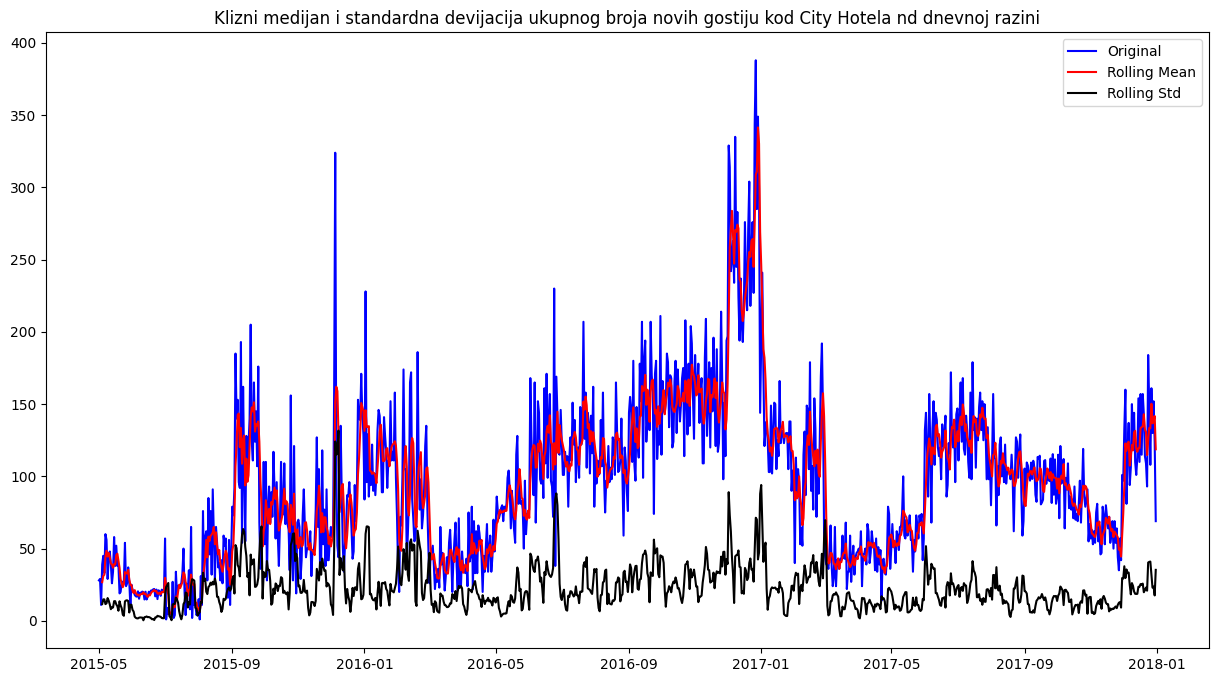

In [74]:
plt.figure(figsize=(15, 8))
rolling_mean_city_daily = NumberOfNewGuestsDailyCity.rolling(window=4).mean()
rolling_std_city_daily = NumberOfNewGuestsDailyCity.rolling(window=4).std()
plt.plot(NumberOfNewGuestsDailyCity, color='blue', label='Original')
plt.plot(rolling_mean_city_daily, color='red', label='Rolling Mean')
plt.plot(rolling_std_city_daily, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja novih gostiju kod City Hotela nd dnevnoj razini')
plt.show()

#### Train / test split podataka

In [75]:
split_ratio  =  0.8

In [76]:
train_test_split_city_daily = int(len(NumberOfNewGuestsDailyCity)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_city_daily} podataka, test {len(NumberOfNewGuestsDailyCity)-train_test_split_city_daily} podataka")

trainCityDaily = NumberOfNewGuestsDailyCity[:train_test_split_city_daily]
testCityDaily = NumberOfNewGuestsDailyCity[train_test_split_city_daily:]

Split 0.8 na train/test, train ima 780 podataka, test 196 podataka


#### Treniranje ARIMA modela na podatke novih gostiju na dnevnoj bazi

- Iz službene dokumentacije (https://alkaline-ml.com/pmdarima/tips_and_tricks.html#period):
   - The m parameter relates to the number of observations per seasonal cycle, and is one that must be known apriori. Typically, m will correspond to some recurrent periodicity such as:
    - 7 - daily
    - 12 - monthly
    - 52 - weekly

- parametar 'd' koristi se ako je potrebno diferencirati vremensku seriju, odnosno postavljamo ga na None ako ne znamo kako diferencirati podatke,
a inače na int vrijednost (tipično 1). Zaklkučak o tome izvodimo iz Augmented Dickey-Fuller Test koji testira jesu li neki podaci u vremenskoj seriji 
stacionarni ili nisu

- Vremenska je serija stacionarna kada su joj  medijan, varijanca, auto-korelacija i slične metrike konstante kroz vrijeme t.
ARIMA pretpostavlja da podaci postaju stacionarni nako diferenciranja, ukoliko je d postavljen an vrijednost veću od nule, što
se naziva diferencijablna stacionarnost. auto_arima određuje i optimalni d.

In [ ]:
stepwise_fit_city_daily = auto_arima(trainCityDaily['ukupno_gostiju'],
                          start_p=1, start_q=1,
                          max_p=5, max_q=5, m=7,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_city_daily.summary()

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(0,0,5)(1,1,1)[7]     je najbolji model te se to preslikava u parametre
- order = (0,0,5)
- seasonal_order = (1,1,1,7)

In [78]:
modelCity_daily = ARIMA(trainCityDaily['ukupno_gostiju'],
                  order=(0,0,5),
                  seasonal_order=(1, 1, 1, 7))

resultCity_daily = modelCity_daily.fit()


##### Predikcije modela na test podacima na dnevnoj bazi

In [80]:
predictionsCityTestDaily = resultCity_daily.predict(train_test_split_city_daily, train_test_split_city_daily + len(testCityDaily) - 1, typ='levels').rename("Predictions")


    #### Predikcija broja novih gostija na dnevnoj razini na testnim podacima


Text(0, 0.5, 'Broj novih gostiju')

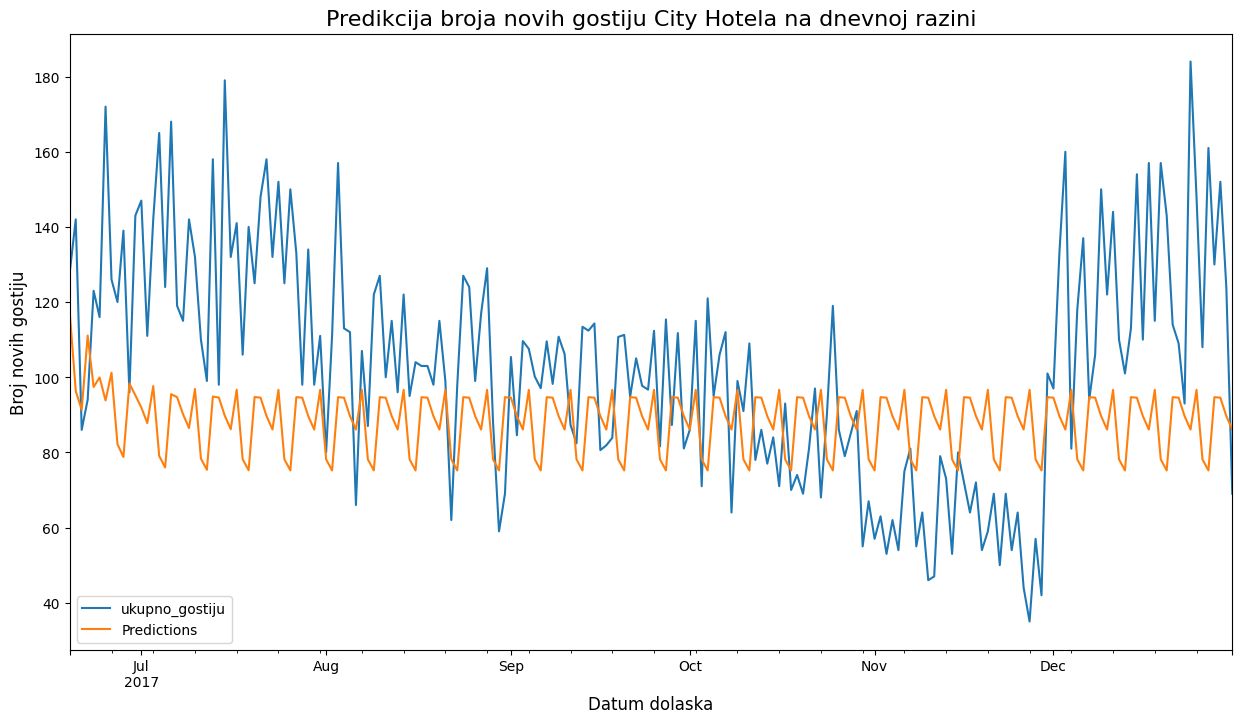

In [81]:
plt.figure(figsize=(15, 8))
testCityDaily['ukupno_gostiju'].plot(legend=True)
predictionsCityTestDaily.plot(legend=True)
plt.title('Predikcija broja novih gostiju City Hotela na dnevnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj novih gostiju', fontsize=12)

Text(0, 0.5, 'Broj novih gostiju')

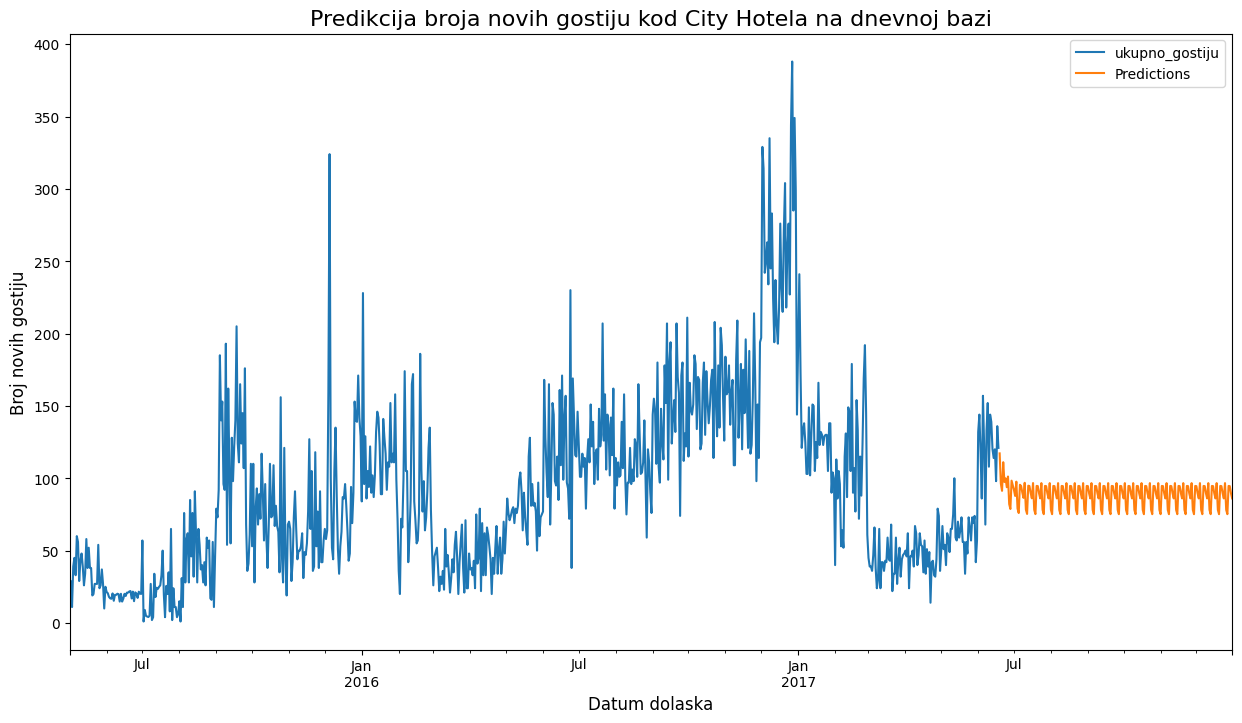

In [82]:
plt.figure(figsize=(15, 8))
trainCityDaily['ukupno_gostiju'].plot(legend=True)
predictionsCityTestDaily.plot(legend=True)
plt.title('Predikcija broja novih gostiju kod City Hotela na dnevnoj bazi', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj novih gostiju', fontsize=12)

In [83]:
MeanAbsPercentageErrCityDaily_test = mean_absolute_percentage_error(testCityDaily, predictionsCityTestDaily)
MeanSquaredErrCityDaily_test = mean_squared_error(testCityDaily, predictionsCityTestDaily)
RootMeanSquaredErrCityDaily_test = root_mean_squared_error(testCityDaily, predictionsCityTestDaily)
print('Test MAPE City Hotel na dnevnoj razini za nove goste: %f' % MeanAbsPercentageErrCityDaily_test)
print('Test MSE City Hotel na dnevnoj razini za nove goste: %f' % MeanSquaredErrCityDaily_test )
print('Test RMSE City Hotel na dnevnoj razini za nove goste: %f' % RootMeanSquaredErrCityDaily_test )

Test MAPE City Hotel na dnevnoj razini za nove goste: 0.270915
Test MSE City Hotel na dnevnoj razini za nove goste: 1174.715193
Test RMSE City Hotel na dnevnoj razini za nove goste: 34.274118


### Predviđanje tjednog broja novih gostiju 


#### Dickey-Fuller test za podatke o dnevnom broju gostiju

In [84]:
CityWeeklyValues = NumberOfNewGuestsWeeklyCity.values
result_city_weekly = adfuller(CityWeeklyValues)
print('ADF Statistic: %f' % result_city_weekly[0])
print('p-value: %f' % result_city_weekly[1])
print('Critical Values:')
for key, value in result_city_weekly[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.789085
p-value: 0.059850
Critical Values:
	1%: -3.480
	5%: -2.883
	10%: -2.578


- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost veća od alfe, ne možemo odbaciti H0, odnosno serija je nestacionarna 

#### Rollling Mean i STD City Hotela

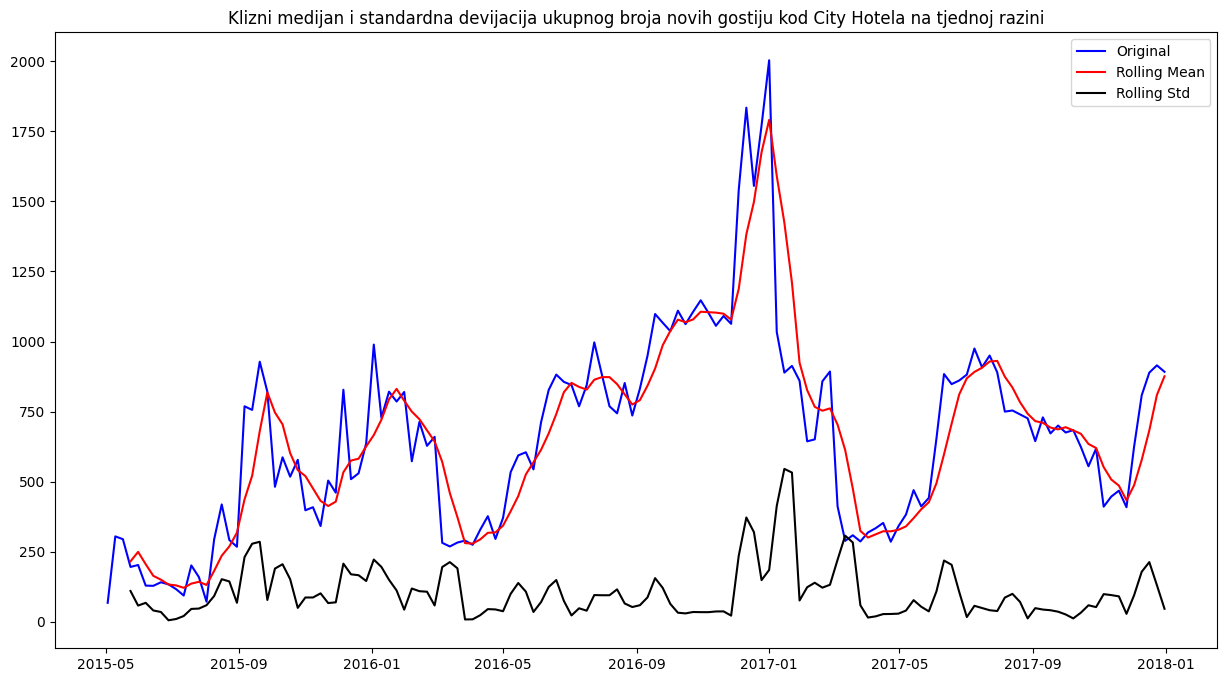

In [86]:
plt.figure(figsize=(15, 8))
rolling_mean_city_weekly = NumberOfNewGuestsWeeklyCity.rolling(window=4).mean()
rolling_std_city_weekly = NumberOfNewGuestsWeeklyCity.rolling(window=4).std()
plt.plot(NumberOfNewGuestsWeeklyCity, color='blue', label='Original')
plt.plot(rolling_mean_city_weekly, color='red', label='Rolling Mean')
plt.plot(rolling_std_city_weekly, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja novih gostiju kod City Hotela na tjednoj razini')
plt.show()

In [87]:
split_ratio  =  0.8

In [88]:
train_test_split_city_weekly = int(len(NumberOfNewGuestsWeeklyCity)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_city_weekly} podataka, test {len(NumberOfNewGuestsWeeklyCity)-train_test_split_city_weekly} podataka")

trainCityWeekly = NumberOfNewGuestsWeeklyCity[:train_test_split_city_weekly]
testCityWeekly = NumberOfNewGuestsWeeklyCity[train_test_split_city_weekly:]

Split 0.8 na train/test, train ima 112 podataka, test 28 podataka


#### Fit ARIMA modela na podatke na tjednoj bazi

In [112]:
stepwise_fit_city_weekly = auto_arima(trainCityWeekly['ukupno_gostiju'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=52,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_city_weekly.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=inf, Time=17.91 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=783.440, Time=0.51 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=786.841, Time=7.07 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=14.69 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=784.889, Time=5.59 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=9.89 sec
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=inf, Time=17.77 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=785.436, Time=0.55 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=785.435, Time=0.64 sec
 ARIMA(1,1,1)(0,1,0)[52]             : AIC=787.210, Time=1.11 sec
 ARIMA(0,1,0)(0,1,0)[52] intercept   : AIC=785.379, Time=0.35 sec

Best model:  ARIMA(0,1,0)(0,1,0)[52]          
Total fit time: 76.119 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  112
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 52)   Log Likelihood                -390.720
Date:                            Thu, 22 Feb 2024   AIC                            783.440
Time:                                    21:31:57   BIC                            785.518
Sample:                                05-03-2015   HQIC                           784.251
                                     - 06-18-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.308e+04   3403.322      9.720      0.000    2.64e+04    3.98e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                48.64
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -0.46
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(0,1,0)(0,1,0)[52] je najbolji model te se to preslikava u parametre
- order = (0,1,0)
- seasonal_order = (0,1,0,52)

In [89]:
modelCityWeekly = ARIMA(trainCityWeekly['ukupno_gostiju'],
                  order=(0, 1, 0),
                  seasonal_order=(0, 1, 0, 52))

resultCityWeekly = modelCityWeekly.fit()


##### Predikcije modela na test podacima na tjednoj bazi

In [90]:
predictionsCityTestWeekly = resultCityWeekly.predict(train_test_split_city_weekly, train_test_split_city_weekly + len(testCityWeekly) - 1, typ='levels').rename("Predictions")


#### Predikcija broja novih gostija na tjednoj razini na testnim podacima


Text(0, 0.5, 'Broj novih gostiju')

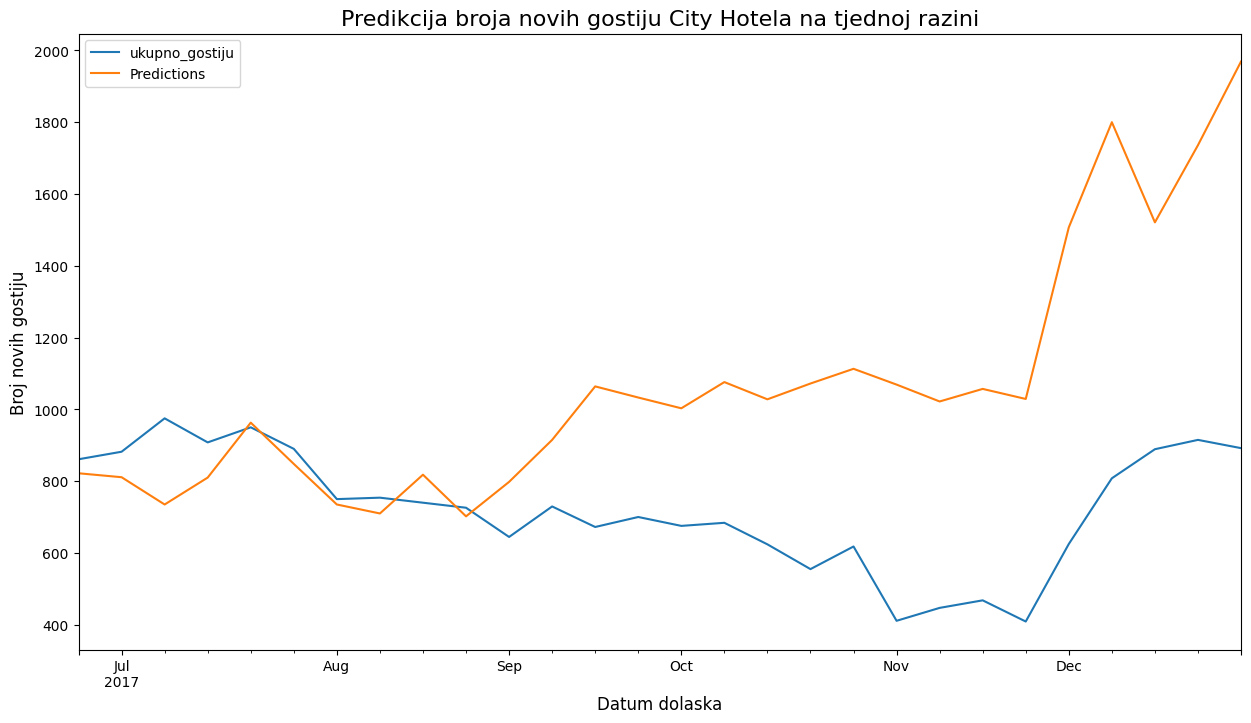

In [91]:
plt.figure(figsize=(15, 8))
testCityWeekly['ukupno_gostiju'].plot(legend=True)
predictionsCityTestWeekly.plot(legend=True)
plt.title('Predikcija broja novih gostiju City Hotela na tjednoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj novih gostiju', fontsize=12)

#### Predikcija broja novih gostiju na tjednoj razini

Text(0, 0.5, 'Broj novih gostiju')

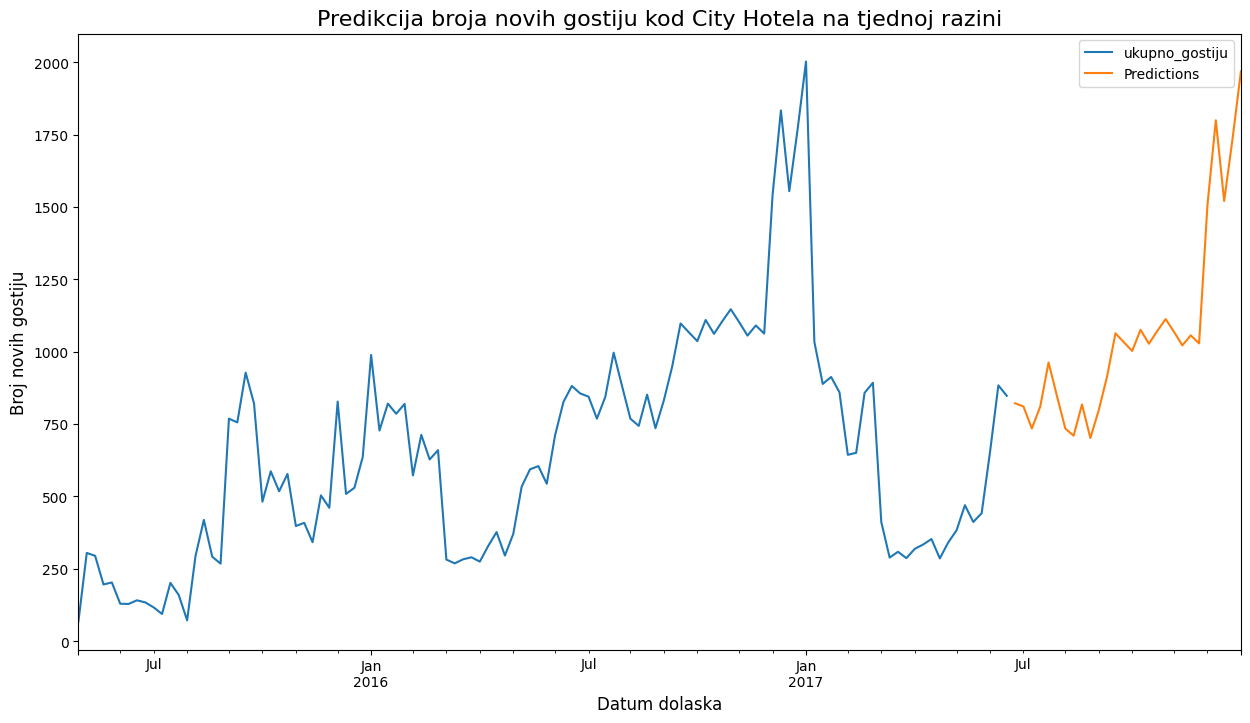

In [92]:
plt.figure(figsize=(15, 8))
trainCityWeekly['ukupno_gostiju'].plot(legend=True)
predictionsCityTestWeekly.plot(legend=True)
plt.title('Predikcija broja novih gostiju kod City Hotela na tjednoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj novih gostiju', fontsize=12)

In [93]:
MeanAbsPercentageErrCityWeekly_test = mean_absolute_percentage_error(testCityWeekly, predictionsCityTestWeekly)
MeanSquaredErrCityWeekly_test = mean_squared_error(testCityWeekly, predictionsCityTestWeekly)
RootMeanSquaredErrCityWeekly_test = root_mean_squared_error(testCityWeekly, predictionsCityTestWeekly)
print('Test MAPE City Hotel tjedna razina: %f' % MeanAbsPercentageErrCityWeekly_test)
print('Test MSE City Hotel tjedna razina: %f' % MeanSquaredErrCityWeekly_test )
print('Test RMSE City Hotel tjedna razina: %f' % RootMeanSquaredErrCityWeekly_test )

Test MAPE City Hotel tjedna razina: 0.602214
Test MSE City Hotel tjedna razina: 244050.702550
Test RMSE City Hotel tjedna razina: 494.014881


### Predviđanje mjesečnog broja novih gostiju 


#### Dickey-Fuller test za podatke o mjesečnom broju gostiju

In [94]:
CityMonthlyValues = NumberOfNewGuestsMonthlyCity.values
result_city_monthly = adfuller(CityMonthlyValues)
print('ADF Statistic: %f' % result_city_monthly [0])
print('p-value: %f' % result_city_monthly [1])
print('Critical Values:')
for key, value in result_city_monthly [4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.790423
p-value: 0.059655
Critical Values:
	1%: -3.661
	5%: -2.961
	10%: -2.619


- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost veća od alfe, ne možemo odbaciti H0, odnosno serija je nestacionarna 

#### Rollling Mean i STD City Hotela Mjesečna razina

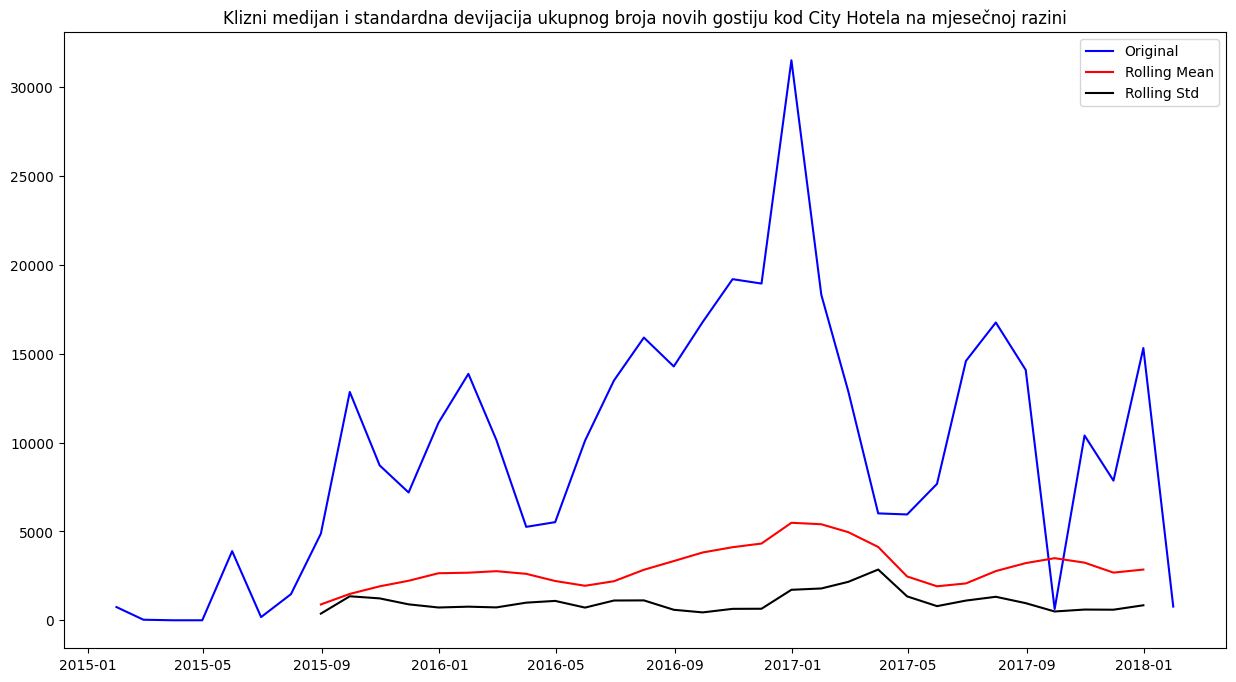

In [95]:
plt.figure(figsize=(15, 8))
rolling_mean_city_monthly  = NumberOfNewGuestsMonthlyCity.rolling(window=4).mean()
rolling_std_city_monthly = NumberOfNewGuestsMonthlyCity.rolling(window=4).std()
plt.plot(NumberOfGuestsMonthlyCity, color='blue', label='Original')
plt.plot(rolling_mean_city_monthly, color='red', label='Rolling Mean')
plt.plot(rolling_std_city_monthly, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja novih gostiju kod City Hotela na mjesečnoj razini')
plt.show()

In [96]:
split_ratio  =  0.8

In [97]:
train_test_split_city_monthly = int(len(NumberOfNewGuestsMonthlyCity)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_city_monthly} podataka, test {len(NumberOfNewGuestsMonthlyCity)-train_test_split_city_monthly} podataka")

trainCityMonthly = NumberOfNewGuestsMonthlyCity[:train_test_split_city_monthly]
testCityMonthly = NumberOfNewGuestsMonthlyCity[train_test_split_city_monthly:]

Split 0.8 na train/test, train ima 25 podataka, test 7 podataka


#### Fit ARIMA modela na podatke na mjesečnoj bazi

In [98]:
stepwise_fit_city_monthly = auto_arima(trainCityMonthly['ukupno_gostiju'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_city_monthly.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=235.418, Time=0.27 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=232.113, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=233.304, Time=0.29 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=234.292, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=239.910, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=234.112, Time=0.05 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=234.106, Time=0.04 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=236.106, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=231.523, Time=0.03 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=233.409, Time=0.06 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=235.402, Time=0.11 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=233.550, Time=0.11 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=233.583, Time=0.12 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=232.281, Time=0.07 sec
 ARIMA(2,0,1)(0,1,0)[12] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   25
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -113.554
Date:                            Fri, 23 Feb 2024   AIC                            231.109
Time:                                    20:46:07   BIC                            232.239
Sample:                                05-31-2015   HQIC                           230.877
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7420      0.135      5.515      0.000       0.478       1.006
sigma2      2.401e+06   1.02e+06      2.365      0.018    4.11e+05    4.39e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):                 0.66
Prob(Q):                              0.47   Prob(JB):                         0.72
Heteroskedasticity (H):               0.08   Skew:                            -0.45
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(1,0,0)(0,1,0)[12] je najbolji model te se to preslikava u parametre
- order = (1,0,0)
- seasonal_order = (0,1,0,12)

In [99]:
modelCityMonthly = ARIMA(trainCityMonthly['ukupno_gostiju'],
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 0, 12))

resultCityMonthly = modelCityMonthly.fit()


##### Predikcije modela na test podacima na mjesečnoj bazi

In [100]:
predictionsCityTestMonthly = resultCityMonthly.predict(train_test_split_city_monthly, train_test_split_city_monthly + len(testCityMonthly) - 1, typ='levels').rename("Predictions")


#### Predikcija broja novih gostija na mjesečnoj razini na testnim podacima


Text(0, 0.5, 'Broj novih gostiju')

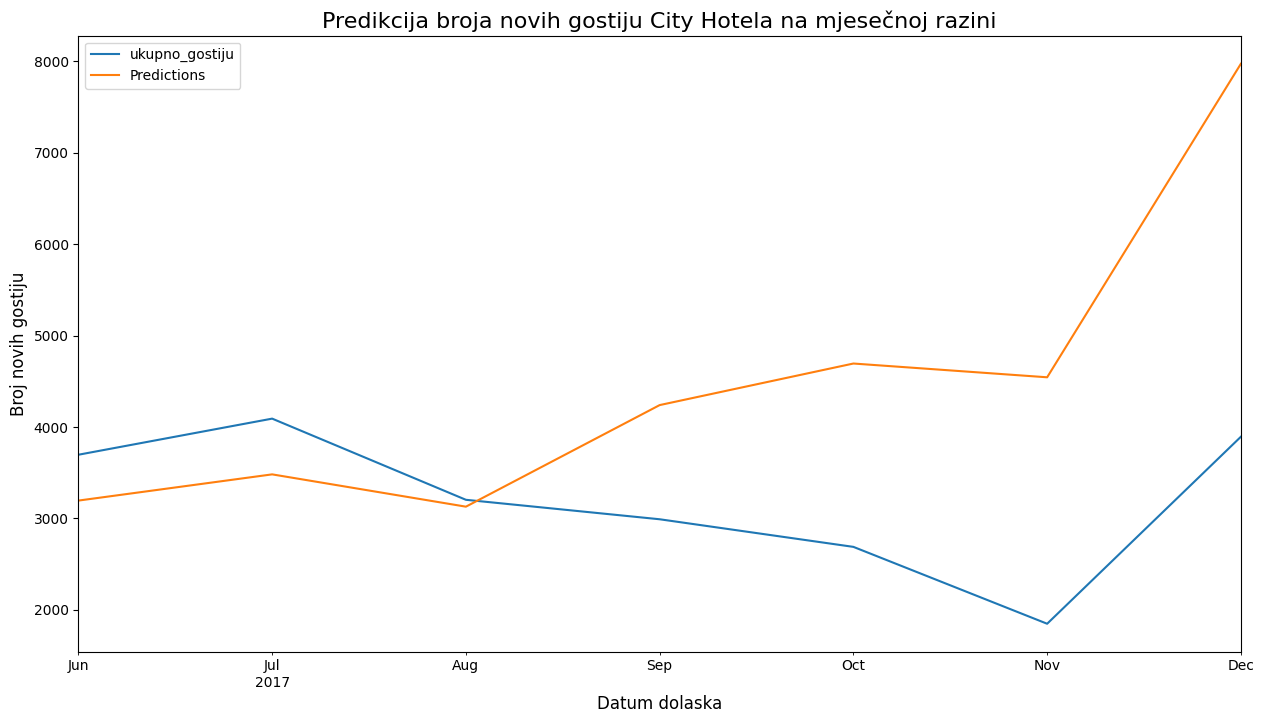

In [101]:
plt.figure(figsize=(15, 8))
testCityMonthly['ukupno_gostiju'].plot(legend=True)
predictionsCityTestMonthly.plot(legend=True)
plt.title('Predikcija broja novih gostiju City Hotela na mjesečnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj novih gostiju', fontsize=12)

#### Predikcija broja novih gostiju na mjesečnoj razini

Text(0, 0.5, 'Broj novih gostiju')

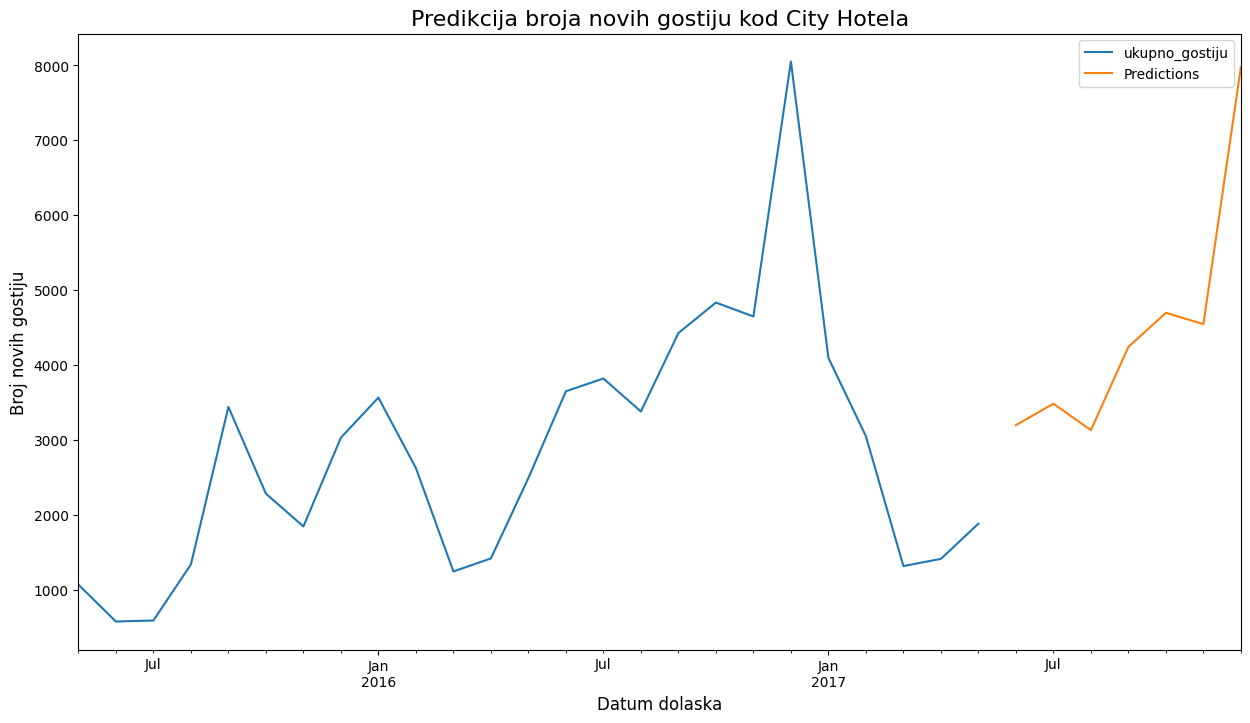

In [102]:
plt.figure(figsize=(15, 8))
trainCityMonthly['ukupno_gostiju'].plot(legend=True)
predictionsCityTestMonthly.plot(legend=True)
plt.title('Predikcija broja novih gostiju kod City Hotela', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj novih gostiju', fontsize=12)

In [103]:
MeanAbsPercentageErrCityMonthly_test = mean_absolute_percentage_error(testCityMonthly, predictionsCityTestMonthly)
MeanSquaredErrCityMonthly_test = mean_squared_error(testCityMonthly, predictionsCityTestMonthly)
RootMeanSquaredErrCityMonthly_test = root_mean_squared_error(testCityMonthly, predictionsCityTestMonthly)
print('Test MAPE City Hotel mjesečna razina: %f' % MeanAbsPercentageErrCityMonthly_test)
print('Test MSE City Hotel mjesečna razina: %f' % MeanSquaredErrCityMonthly_test )
print('Test RMSE City Hotel mjesečna razina: %f' % RootMeanSquaredErrCityMonthly_test )

Test MAPE City Hotel mjesečna razina: 0.568370
Test MSE City Hotel mjesečna razina: 4304658.178655
Test RMSE City Hotel mjesečna razina: 2074.767018


## ARIMA model za predviđanje budućeg broja novih gostiju - Resort Hotel 


### Predviđanje dnevnog broja novih gostiju 


#### Dickey-Fuller test za podatke o dnevnom broju novih gostiju

In [104]:
ResortDailyValues = NumberOfNewGuestsDailyResort.values
result_resort_daily = adfuller(ResortDailyValues)
print('ADF Statistic: %f' % result_resort_daily[0])
print('p-value: %f' % result_resort_daily[1])
print('Critical Values:')
for key, value in result_resort_daily[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.485274
p-value: 0.000209
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost manja od alfe,  možemo odbaciti H0, odnosno serija je stacionarna 

#### Rollling Mean i STD Resort Hotela na dnevnioj razini

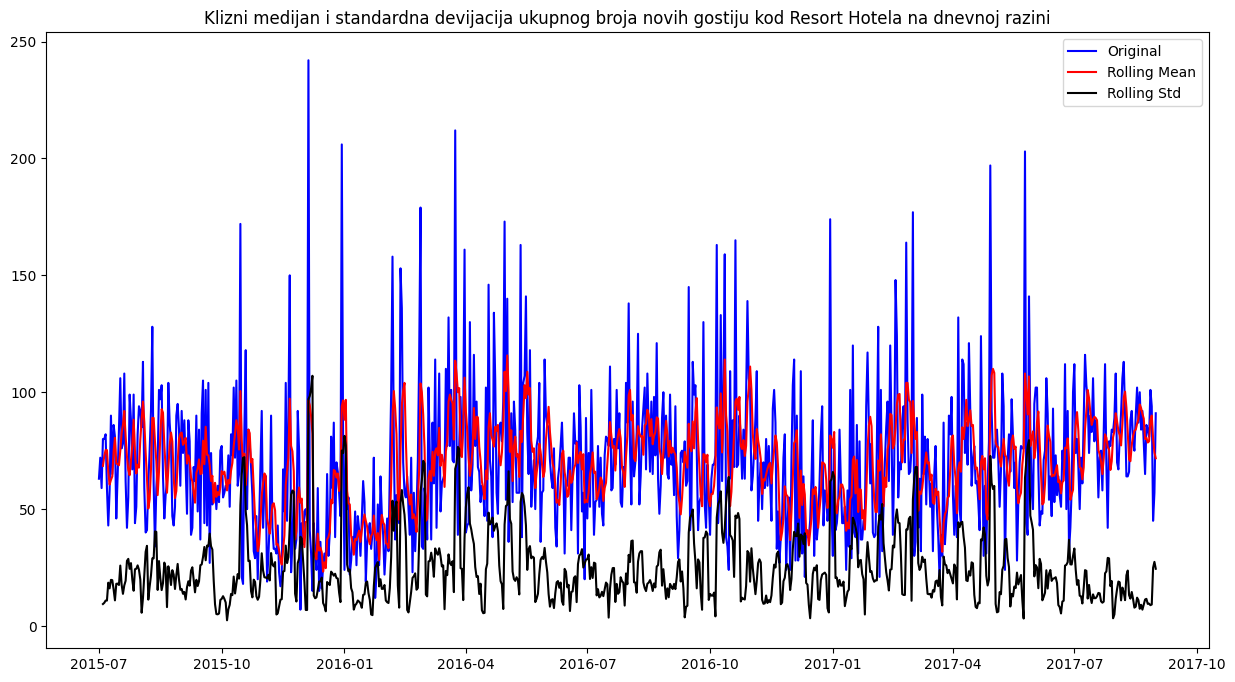

In [106]:
plt.figure(figsize=(15, 8))
rolling_mean_resort_daily = NumberOfNewGuestsDailyResort.rolling(window=4).mean()
rolling_std_resort_daily  = NumberOfNewGuestsDailyResort.rolling(window=4).std()
plt.plot(NumberOfNewGuestsDailyResort, color='blue', label='Original')
plt.plot(rolling_mean_resort_daily , color='red', label='Rolling Mean')
plt.plot(rolling_std_resort_daily , color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja novih gostiju kod Resort Hotela na dnevnoj razini')
plt.show()

In [107]:
split_ratio  =  0.8

In [108]:
train_test_split_resort_daily = int(len(NumberOfNewGuestsDailyResort)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_resort_daily} podataka, test {len(NumberOfNewGuestsDailyResort)-train_test_split_resort_daily} podataka")

trainResortDaily = NumberOfNewGuestsDailyResort[:train_test_split_resort_daily]
testResortDaily = NumberOfNewGuestsDailyResort[train_test_split_resort_daily:]

Split 0.8 na train/test, train ima 634 podataka, test 159 podataka


#### Fit ARIMA modela na podatke na dnevnoj bazi

In [139]:
stepwise_fit_resort_daily = auto_arima(trainResortDaily['ukupno_gostiju'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=7,
                          start_P=0, seasonal=True,
                          d=0, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_resort_daily.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=6063.789, Time=1.45 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=6341.594, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=6176.142, Time=0.83 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=6062.540, Time=1.00 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=6339.624, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=6340.951, Time=0.25 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=1.72 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=inf, Time=2.66 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=6175.946, Time=0.53 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=9.22 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=6071.644, Time=0.42 sec
 ARIMA(0,0,2)(0,1,1)[7] intercept   : AIC=6064.322, Time=1.84 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=6062.920, Time=1.21 sec
 ARIMA(1,0,2)(0,1,1)[7] intercept   : AIC=6065.609, Time=3.12 sec
 ARIMA(0,0,1)(0,1,1)[7]             : AIC=6060.6

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  634
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -3027.326
Date:                           Thu, 22 Feb 2024   AIC                           6060.653
Time:                                   21:36:47   BIC                           6073.976
Sample:                               07-01-2015   HQIC                          6065.829
                                    - 03-25-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1394      0.036      3.901      0.000       0.069       0.209
ma.S.L7       -0.8485      0.022    -39.392      0.000      -0.891      -0.806
sigma2       901.8391     29.013     31.084      0.000     844.974     958.704
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               652.42
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             1.31
Prob(H) (two-sided):                  0.46   Kurtosis:                         7.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(0,0,1)(0,1,1)[7]    je najbolji model te se to preslikava u parametre
- order = (0, 0 ,1)
- seasonal_order = (0,1,1,7)


In [109]:
modelResort_daily = ARIMA(trainResortDaily['ukupno_gostiju'],
                  order=(0, 0, 1),
                  seasonal_order=(0, 1, 1, 7))

resultResort_daily = modelResort_daily.fit()


##### Predikcije modela na test podacima na dnevnoj bazi

In [135]:
predictionsResortTestDaily = resultResort_daily.predict(train_test_split_resort_daily, train_test_split_resort_daily + len(testResortDaily) - 1, typ='levels').rename("Predictions")


#### Predikcija broja novih gostija na dnevnoj razini na testnim podacima


Text(0, 0.5, 'Broj novih gostiju')

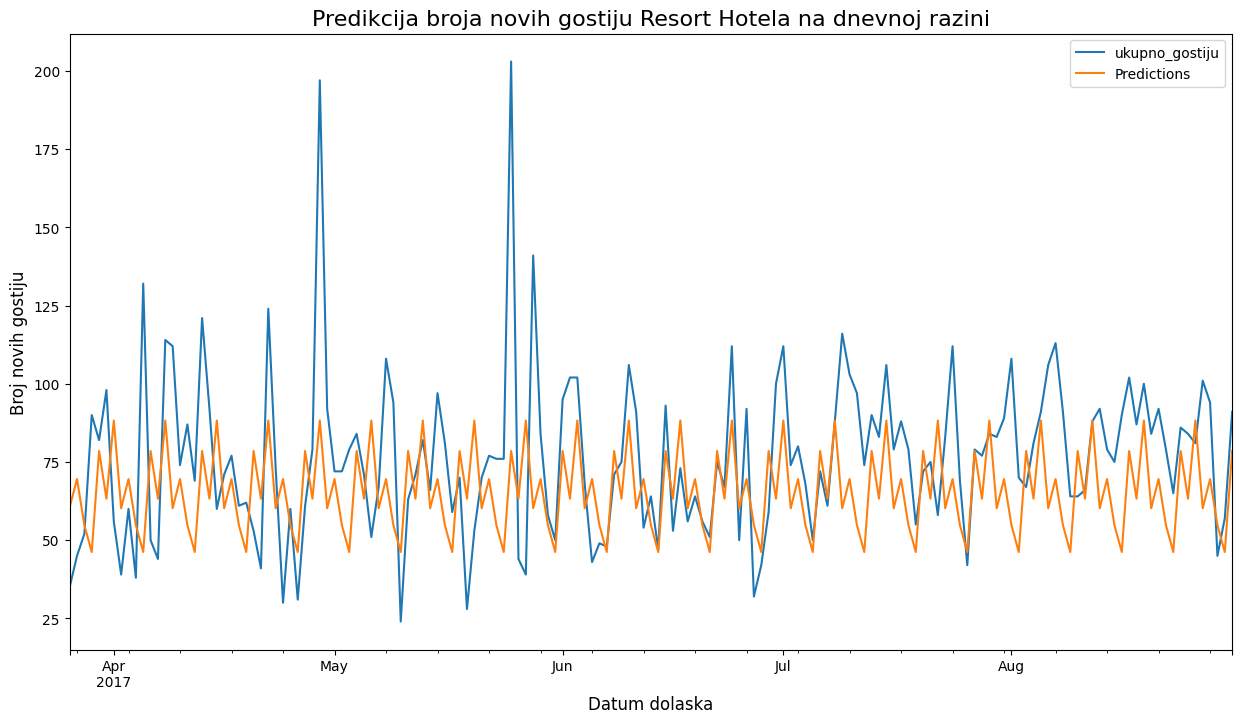

In [136]:
plt.figure(figsize=(15, 8))
testResortDaily['ukupno_gostiju'].plot(legend=True)
predictionsResortTestDaily.plot(legend=True)
plt.title('Predikcija broja novih gostiju Resort Hotela na dnevnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj novih gostiju', fontsize=12)

Text(0, 0.5, 'Broj novih gostiju')

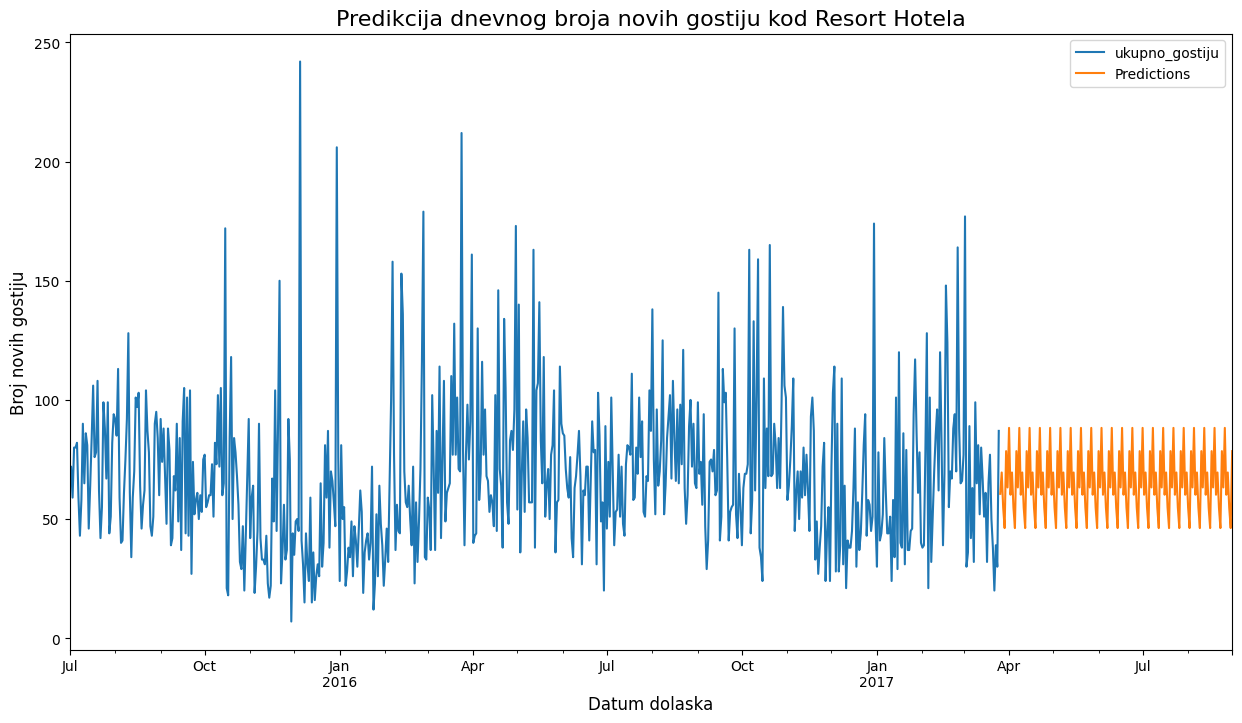

In [137]:
plt.figure(figsize=(15, 8))
trainResortDaily['ukupno_gostiju'].plot(legend=True)
predictionsResortTestDaily.plot(legend=True)
plt.title('Predikcija dnevnog broja novih gostiju kod Resort Hotela', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj novih gostiju', fontsize=12)

In [138]:
MeanAbsPercentageErrResortDaily_test = mean_absolute_percentage_error(testResortDaily, predictionsResortTestDaily)
MeanSquaredErrResortDaily_test = mean_squared_error(testResortDaily, predictionsResortTestDaily)
RootMeanSquaredErrResortDaily_test = root_mean_squared_error(testResortDaily, predictionsResortTestDaily)
print('Test MAPE Resort Hotel na dnevnoj razini: %f' % MeanAbsPercentageErrResortDaily_test)
print('Test MSE City Hotel na dnevnoj razini: %f' % MeanSquaredErrCityDaily_test )
print('Test RMSE City Hotel na dnevnoj razini: %f' % RootMeanSquaredErrCityDaily_test )

Test MAPE Resort Hotel na dnevnoj razini: 0.279172
Test MSE City Hotel na dnevnoj razini: 1174.715193
Test RMSE City Hotel na dnevnoj razini: 34.274118


### Predviđanje tjednog broja gostiju 


#### Dickey-Fuller test za podatke o tjednom broju  gostiju

In [113]:
ResortWeeklyValues = NumberOfNewGuestsWeeklyResort.values
result_resort_weekly = adfuller(ResortWeeklyValues)
print('ADF Statistic: %f' % result_resort_weekly [0])
print('p-value: %f' % result_resort_weekly [1])
print('Critical Values:')
for key, value in result_resort_weekly [4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.971071
p-value: 0.037686
Critical Values:
	1%: -3.493
	5%: -2.889
	10%: -2.581


- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost manja od alfe,  možemo odbaciti H0, odnosno serija je stacionarna 

#### Rollling Mean i STD Resort Hotela na tjednoj razini

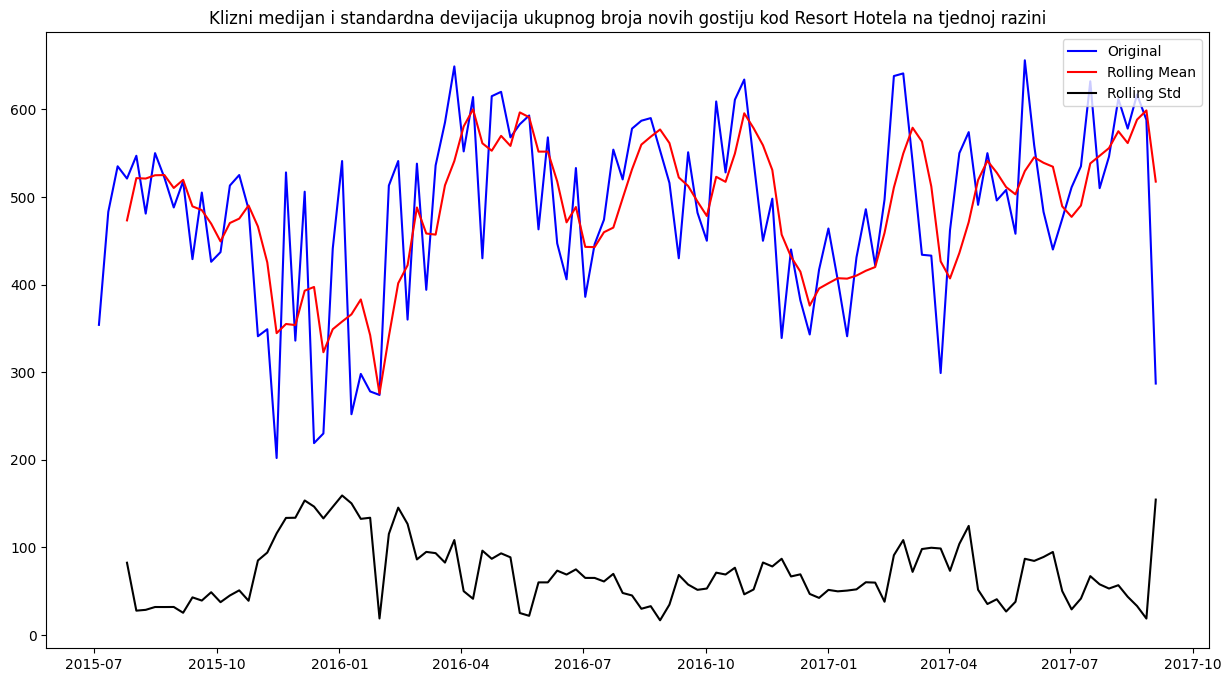

In [114]:
plt.figure(figsize=(15, 8))
rolling_mean_resort_weekly = NumberOfNewGuestsWeeklyResort.rolling(window=4).mean()
rolling_std_resort_weekly = NumberOfNewGuestsWeeklyResort.rolling(window=4).std()
plt.plot(NumberOfNewGuestsWeeklyResort, color='blue', label='Original')
plt.plot(rolling_mean_resort_weekly, color='red', label='Rolling Mean')
plt.plot(rolling_std_resort_weekly, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja novih gostiju kod Resort Hotela na tjednoj razini')
plt.show()

In [115]:
split_ratio  =  0.8

In [116]:
train_test_split_resort_weekly = int(len(NumberOfNewGuestsWeeklyResort)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_resort_weekly} podataka, test {len(NumberOfNewGuestsWeeklyResort)-train_test_split_resort_weekly} podataka")

trainResortWeekly = NumberOfNewGuestsWeeklyResort[:train_test_split_resort_weekly]
testResortWeekly = NumberOfNewGuestsWeeklyResort[train_test_split_resort_weekly:]

Split 0.8 na train/test, train ima 91 podataka, test 23 podataka


#### Fit ARIMA modela na podatke na tjednoj bazi

In [150]:
stepwise_fit_resort_weekly = auto_arima(trainResortWeekly['ukupno_gostiju'], 
                          start_p=1, start_q=1,
                          max_p=3, max_q=3, m=54,
                          start_P=0, seasonal=True,
                          d=0, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_resort_weekly.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[54] intercept   : AIC=inf, Time=17.18 sec
 ARIMA(0,0,0)(0,1,0)[54] intercept   : AIC=460.118, Time=0.20 sec
 ARIMA(1,0,0)(1,1,0)[54] intercept   : AIC=inf, Time=14.98 sec
 ARIMA(0,0,1)(0,1,1)[54] intercept   : AIC=inf, Time=9.34 sec
 ARIMA(0,0,0)(0,1,0)[54]             : AIC=465.938, Time=0.21 sec
 ARIMA(0,0,0)(1,1,0)[54] intercept   : AIC=inf, Time=12.03 sec
 ARIMA(0,0,0)(0,1,1)[54] intercept   : AIC=inf, Time=6.37 sec
 ARIMA(0,0,0)(1,1,1)[54] intercept   : AIC=inf, Time=15.00 sec
 ARIMA(1,0,0)(0,1,0)[54] intercept   : AIC=461.940, Time=1.04 sec
 ARIMA(0,0,1)(0,1,0)[54] intercept   : AIC=461.929, Time=0.98 sec
 ARIMA(1,0,1)(0,1,0)[54] intercept   : AIC=463.927, Time=1.02 sec

Best model:  ARIMA(0,0,0)(0,1,0)[54] intercept
Total fit time: 78.401 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   91
Model:             SARIMAX(0, 1, 0, 54)   Log Likelihood                -228.059
Date:                  Thu, 22 Feb 2024   AIC                            460.118
Time:                          21:40:46   BIC                            463.340
Sample:                      07-05-2015   HQIC                           461.254
                           - 03-26-2017                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     55.7838     22.069      2.528      0.011      12.529      99.039
sigma2      1.322e+04   3533.878      3.741      0.000    6295.679    2.01e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 3.39
Prob(Q):                              0.69   Prob(JB):                         0.18
Heteroskedasticity (H):               6.48   Skew:                            -0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(0,0,0)(0,1,0)[54]    je najbolji model te se to preslikava u parametre
- order = (0,0,0)
- seasonal_order = (0,1,0)[54] 


In [117]:
modelResort_weekly = ARIMA(trainResortWeekly['ukupno_gostiju'],
                  order=(0, 0, 0),
                  seasonal_order=(0, 1, 0, 54))

resultResort_weekly= modelResort_weekly.fit()


##### Predikcije modela na test podacima na tjednoj bazi

In [119]:
predictionsResortTestWeekly = resultResort_weekly.predict(train_test_split_resort_weekly, train_test_split_resort_weekly + len(testResortWeekly) - 1, typ='levels').rename("Predictions")


#### Predikcija broja novih gostiju na tjednoj razini na testnim podacima


Text(0, 0.5, 'Broj novih gostiju')

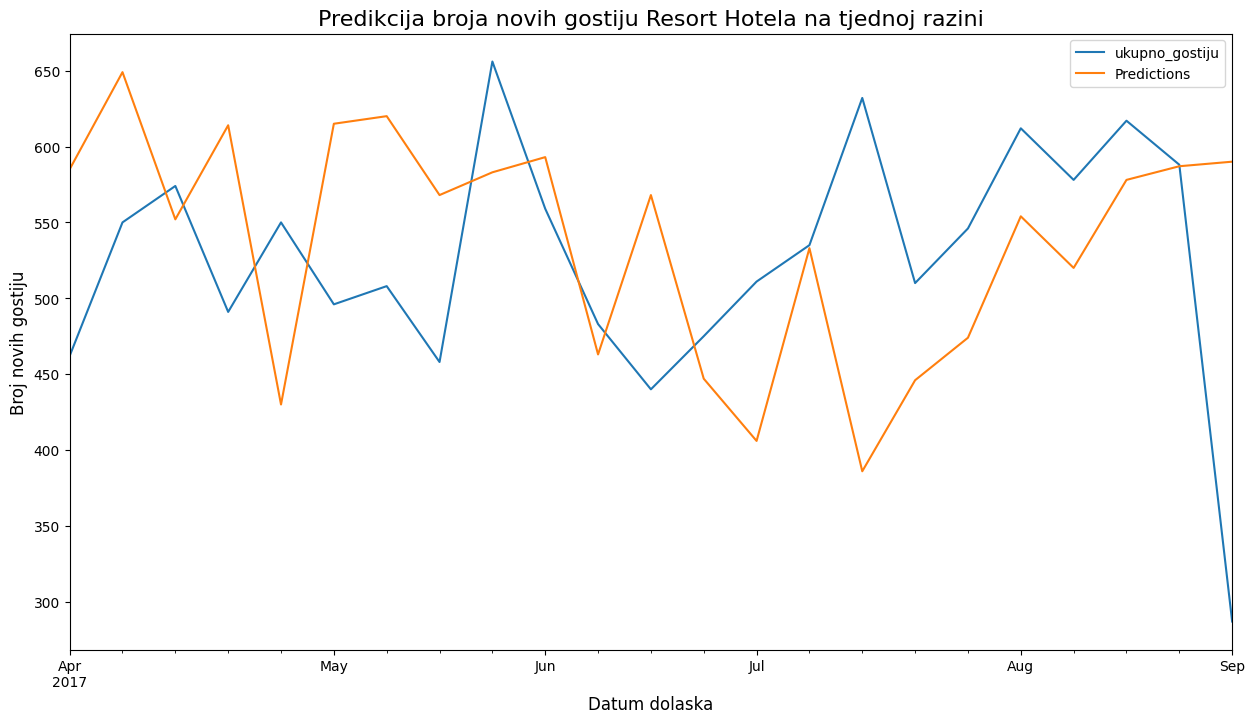

In [120]:
plt.figure(figsize=(15, 8))
testResortWeekly['ukupno_gostiju'].plot(legend=True)
predictionsResortTestWeekly.plot(legend=True)
plt.title('Predikcija broja novih gostiju Resort Hotela na tjednoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj novih gostiju', fontsize=12)

Text(0, 0.5, 'Broj novih gostiju')

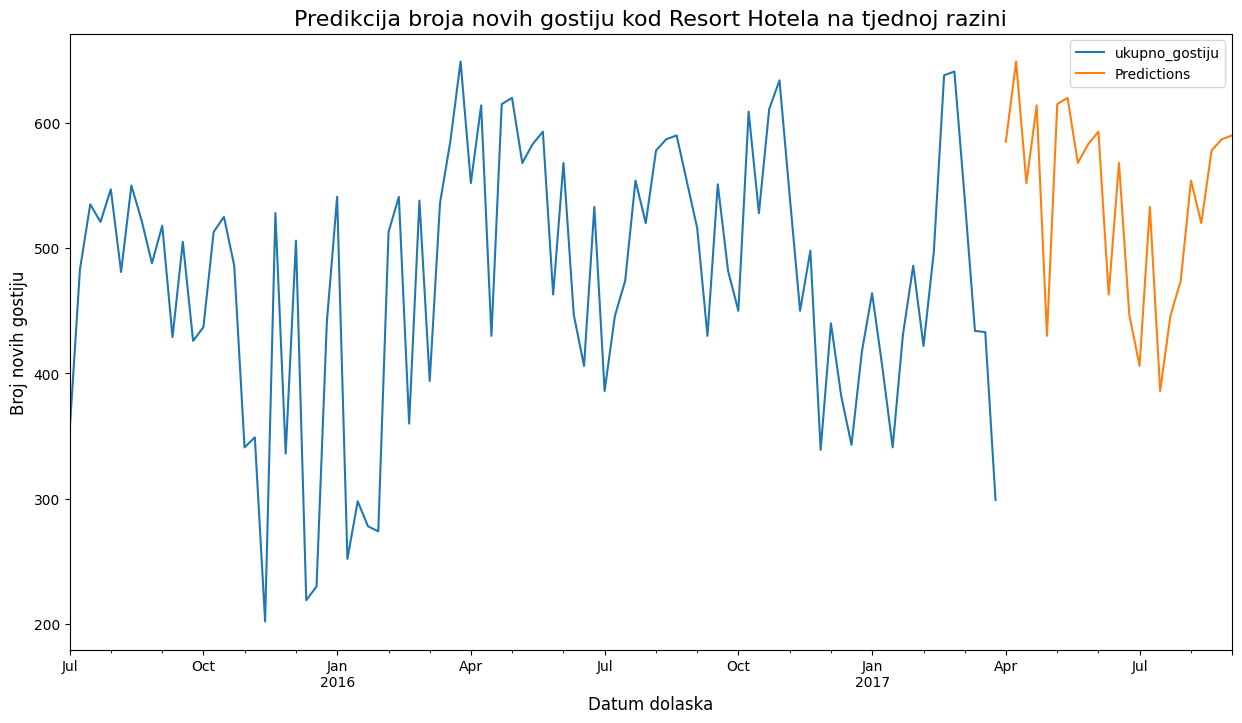

In [121]:
plt.figure(figsize=(15, 8))
trainResortWeekly['ukupno_gostiju'].plot(legend=True)
predictionsResortTestWeekly.plot(legend=True)
plt.title('Predikcija broja novih gostiju kod Resort Hotela na tjednoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj novih gostiju', fontsize=12)

In [122]:
MeanAbsPercentageErrResortWeekly_test = mean_absolute_percentage_error(testResortWeekly, predictionsResortTestWeekly)
MeanSquaredErrResortWeekly_test = mean_squared_error(testResortWeekly, predictionsResortTestWeekly)
RootMeanSquaredErrResortWeekly_test = root_mean_squared_error(testResortWeekly, predictionsResortTestWeekly)
print('Test MAPE Resort Hotel na tjednoj razini: %f' % MeanAbsPercentageErrResortWeekly_test)
print('Test MSE City Hotel na tjednoj razini: %f' % MeanSquaredErrCityWeekly_test)
print('Test RMSE City Hotel na tjednoj razini: %f' % RootMeanSquaredErrCityWeekly_test )

Test MAPE Resort Hotel na tjednoj razini: 0.190816
Test MSE City Hotel na tjednoj razini: 244050.702550
Test RMSE City Hotel na tjednoj razini: 494.014881


### Predviđanje mjesečnog broja novih gostiju 


#### Dickey-Fuller test za podatke o mjesečnom broju gostiju

In [123]:
ResortMonthlyValues = NumberOfNewGuestsMonthlyResort.values
result_resort_monthly = adfuller(ResortMonthlyValues)
print('ADF Statistic: %f' % result_resort_monthly[0])
print('p-value: %f' % result_resort_monthly[1])
print('Critical Values:')
for key, value in result_resort_monthly[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.162363
p-value: 0.022269
Critical Values:
	1%: -3.724
	5%: -2.986
	10%: -2.633


- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost manje od alfe, možemo odbaciti H0, odnosno serija je stacionarna 

#### Rollling Mean i STD Resort Hotela na mjesečnoj razini

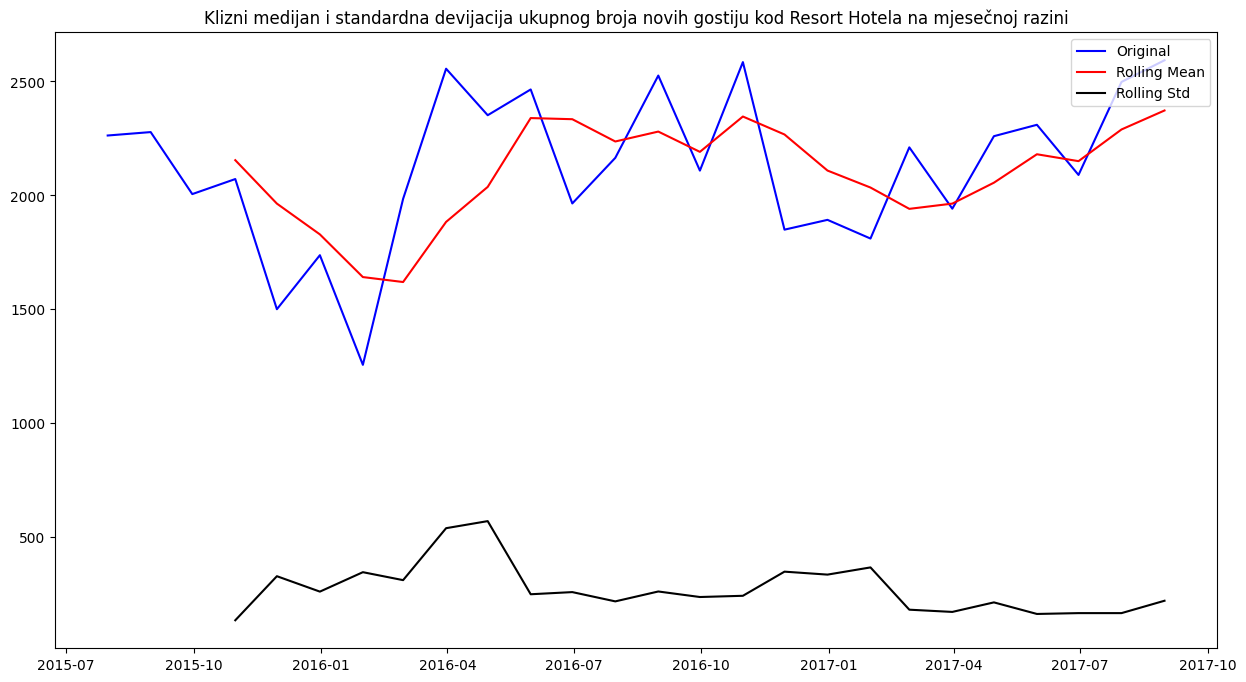

In [124]:
plt.figure(figsize=(15, 8))
rolling_mean_resort_monthly = NumberOfNewGuestsMonthlyResort.rolling(window=4).mean()
rolling_std_resort_monthly = NumberOfNewGuestsMonthlyResort.rolling(window=4).std()
plt.plot(NumberOfNewGuestsMonthlyResort, color='blue', label='Original')
plt.plot(rolling_mean_resort_monthly, color='red', label='Rolling Mean')
plt.plot(rolling_std_resort_monthly, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja novih gostiju kod Resort Hotela na mjesečnoj razini')
plt.show()

In [125]:
split_ratio  =  0.8

In [126]:
train_test_split_resort_monthly = int(len(NumberOfNewGuestsMonthlyResort)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_resort_monthly} podataka, test {len(NumberOfNewGuestsMonthlyResort)-train_test_split_resort_monthly} podataka")

trainResortMonthly = NumberOfNewGuestsMonthlyResort[:train_test_split_resort_monthly]
testResortMonthly = NumberOfNewGuestsMonthlyResort[train_test_split_resort_monthly:]

Split 0.8 na train/test, train ima 20 podataka, test 6 podataka


In [162]:
stepwise_fit_resort_monthly = auto_arima(trainResortMonthly['ukupno_gostiju'], 
                          start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=0, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_resort_monthly.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=116.638, Time=0.54 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=111.557, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=114.347, Time=0.33 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=117.080, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=113.036, Time=0.07 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=112.960, Time=0.11 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 2.307 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   20
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                 -53.779
Date:                  Thu, 22 Feb 2024   AIC                            111.557
Time:                          21:41:29   BIC                            111.716
Sample:                      07-31-2015   HQIC                           110.486
                           - 02-28-2017                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    251.1250     71.380      3.518      0.000     111.223     391.027
sigma2      4.041e+04   2.56e+04      1.581      0.114   -9672.934    9.05e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.60   Prob(JB):                         0.91
Heteroskedasticity (H):               0.64   Skew:                            -0.10
Prob(H) (two-sided):                  0.72   Kurtosis:                         2.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(0,0,0)(0,1,0)[12]    je najbolji model te se to preslikava u parametre
- order = (0,0,0)
- seasonal_order = (0,1,0)[12] 


In [127]:
modelResort_monthly = ARIMA(trainResortMonthly['ukupno_gostiju'],
                  order=(0, 0, 0),
                  seasonal_order=(0, 1, 0, 12))

resultResort_monthly= modelResort_monthly.fit()


##### Predikcije modela na test podacima na mjesečnoj bazi

In [128]:
predictionsResortTestMonthly = resultResort_monthly.predict(train_test_split_resort_monthly, train_test_split_resort_monthly + len(testResortMonthly) - 1, typ='levels').rename("Predictions")


#### Predikcija broja gostija na mjesečnoj razini na testnim podacima


Text(0, 0.5, 'Broj novih gostiju')

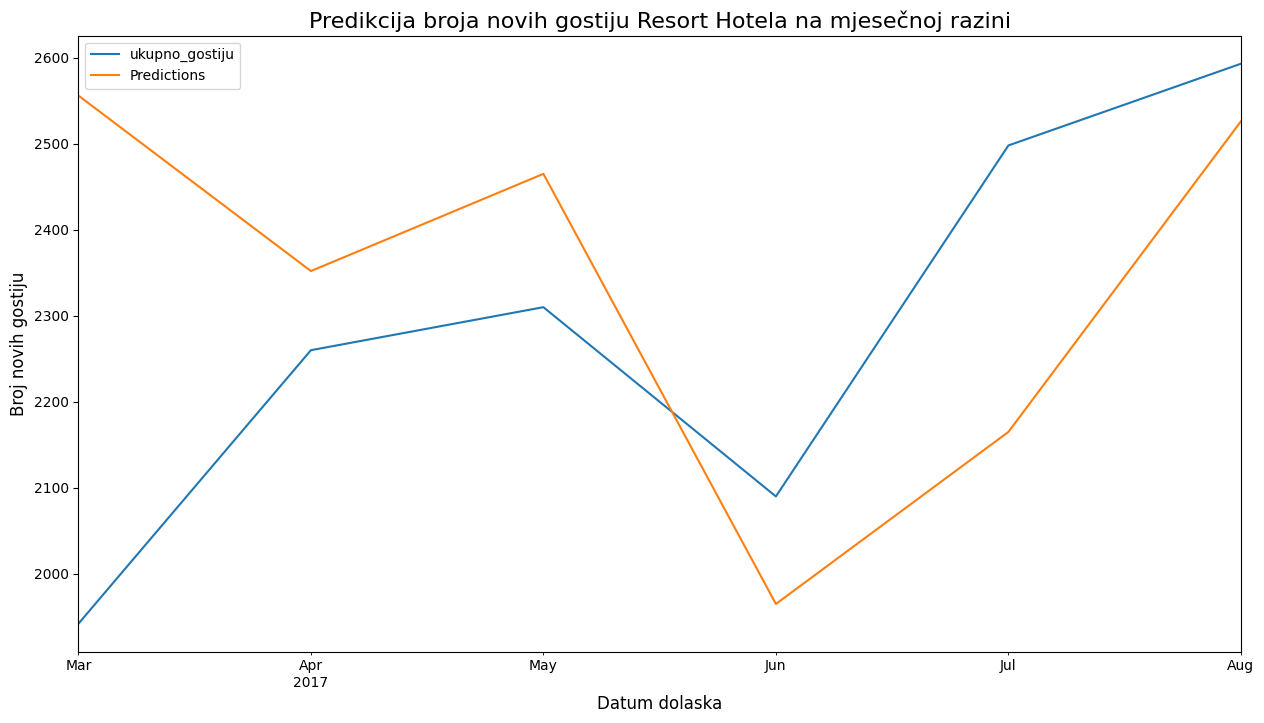

In [130]:
plt.figure(figsize=(15, 8))
testResortMonthly['ukupno_gostiju'].plot(legend=True)
predictionsResortTestMonthly.plot(legend=True)
plt.title('Predikcija broja novih gostiju Resort Hotela na mjesečnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj novih gostiju', fontsize=12)

Text(0, 0.5, 'Broj novih gostiju')

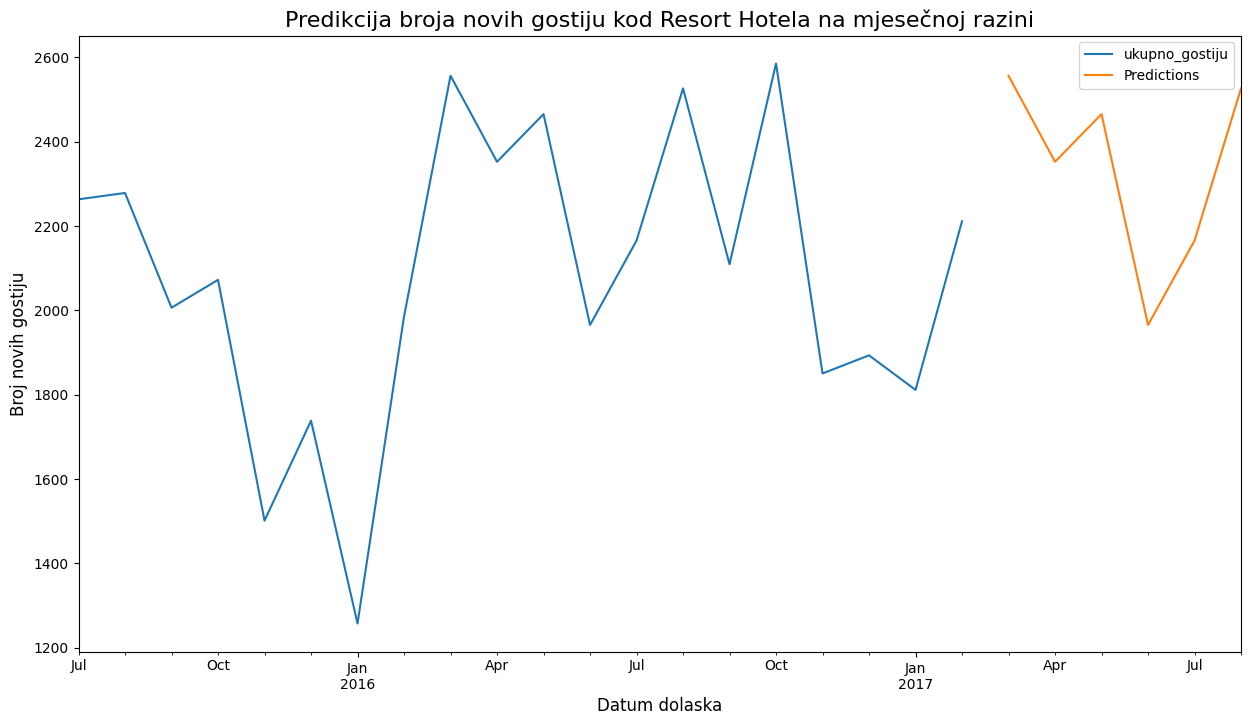

In [131]:
plt.figure(figsize=(15, 8))
trainResortMonthly['ukupno_gostiju'].plot(legend=True)
predictionsResortTestMonthly.plot(legend=True)
plt.title('Predikcija broja novih gostiju kod Resort Hotela na mjesečnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj novih gostiju', fontsize=12)

In [132]:
MeanAbsPercentageErrResortMonthly_test = mean_absolute_percentage_error(testResortMonthly, predictionsResortTestMonthly)
MeanSquaredErrResortMonthly_test = mean_squared_error(testResortMonthly, predictionsResortTestMonthly)
RootMeanSquaredErrResortMonthly_test = root_mean_squared_error(testResortMonthly, predictionsResortTestMonthly)
print('Test MAPE Resort Hotel na mjesečnoj razini: %f' % MeanAbsPercentageErrResortMonthly_test )
print('Test MSE City Hotel na mjesečnoj razini: %f' % MeanSquaredErrResortMonthly_test)
print('Test RMSE City Hotel na mjesečnoj  razini: %f' % RootMeanSquaredErrResortMonthly_test)

Test MAPE Resort Hotel na mjesečnoj razini: 0.107155
Test MSE City Hotel na mjesečnoj razini: 90081.333333
Test RMSE City Hotel na mjesečnoj  razini: 300.135525


In [133]:
MeanAbsPercentageErrResortMonthly_test = mean_absolute_percentage_error(testResortMonthly, predictionsResortTestMonthly)
print('Test MAPE Resort Hotel na mjesečnoj razini: %f' % MeanAbsPercentageErrResortMonthly_test)

Test MAPE Resort Hotel na mjesečnoj razini: 0.107155


## Pregled svih rezultata predikcije broja novih gostiju kod oba hotela 

In [139]:
errors_data = {
    'Hotel': ['City', 'City', 'City', 'Resort', 'Resort', 'Resort'],
    'Time Range': ['Daily', 'Weekly', 'Monthly', 'Daily', 'Weekly', 'Monthly'],
    'MeanAbsPercentageError/%': [
        MeanAbsPercentageErrCityDaily_test,
        MeanAbsPercentageErrCityWeekly_test,
        MeanAbsPercentageErrCityMonthly_test,
        MeanAbsPercentageErrResortDaily_test,
        MeanAbsPercentageErrResortWeekly_test,
        MeanAbsPercentageErrResortMonthly_test
    ],
    'MeanSquaredError/%': [
        MeanSquaredErrCityDaily_test,
        MeanSquaredErrCityWeekly_test,
        MeanSquaredErrCityMonthly_test,
        MeanSquaredErrResortDaily_test,
        MeanSquaredErrResortWeekly_test ,
        MeanSquaredErrResortMonthly_test
    ],
    'RootMeanSquaredError/%': [
        RootMeanSquaredErrCityDaily_test,
        RootMeanSquaredErrCityWeekly_test,
        RootMeanSquaredErrCityMonthly_test,
        RootMeanSquaredErrResortDaily_test,
        RootMeanSquaredErrResortWeekly_test ,
        RootMeanSquaredErrResortMonthly_test
    ],
    
}

errors_df = pd.DataFrame(errors_data)
errors_df = errors_df.style.format({'MeanAbsPercentageError': "{:.2f}"})

In [140]:
errors_df

,Hotel,Time Range,MeanAbsPercentageError/%,MeanSquaredError/%,RootMeanSquaredError/%
0,City,Daily,0.270915,1174.715193,34.274118
1,City,Weekly,0.602214,244050.702550,494.014881
2,City,Monthly,0.568370,4304658.178655,2074.767018
3,Resort,Daily,0.279172,766.610161,27.687726
4,Resort,Weekly,0.190816,12986.304348,113.957467
5,Resort,Monthly,0.107155,90081.333333,300.135525


# Predikcija zauzetosti (ukupnog broja gostiju)